<center><h2>Principal Components Analysis</h2></center>

<center><h5> Homework 1 </h5></center>


#### Libraries & Configurations

In [1]:
# Importing necessary libraries
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib.lines import Line2D
from IPython.display import display # to display variables in a "nice" way
from mpl_toolkits.mplot3d import Axes3D

# Setting the style for plots
plt.style.use('ggplot')

# Configuring display options for pandas
pd.set_option('display.max_columns', None)  # Show all columns of dataframes
pd.set_option('display.max_rows', 100)  # Set the maximum number of rows to display

# Setting the default size for plots
plt.rcParams['figure.figsize'] = [10, 6]

#### 0. Preparation

In [2]:
# random seed
rs = 287634

# set the random seed in numpy
np.random.seed(rs)

#### Exercise 1 (Loading and Preparing the Data)

##### 1.1

In [3]:
# File path
file_path = './/cla4lsp customers.csv'

# read the data into df_tot where we have the raw data
df_tot = pd.read_csv(file_path, delimiter='\t')

##### 1.2

In [4]:
# Sampling two-thirds of the dataframe rows randomly
workdf = df_tot.sample(frac=2/3, random_state=rs)

workdf.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
1636  5209        1954  Graduation       Divorced  50002.0        0         1   
1319  8749        1984  Graduation       Together  37235.0        1         0   
948   6515        1977  Graduation       Together  39771.0        1         0   
1597  3409        1984  Graduation         Single  36108.0        1         0   
265   6690        1966      Master        Married  38179.0        1         1   

     Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  \
1636  17-06-2013       21       443          5               71   
1319  01-02-2014       68        20          2                9   
948   06-12-2013       92         6          2               18   
1597  15-10-2013       68       141          8              129   
265   14-03-2013       30        38          4               22   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
1636               21                16            82                  2   
1319                4                 6            20                  1   
948                 2                 8            14                  1   
1597                3                11            47                  3   
265                 4                 2            20                  4   

      NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
1636                8                    2                  7   
1319                1                    1                  2   
948                 2                    0                  3   
1597                7                    1                  4   
265                 3                    1                  3   

      NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
1636                  7             0             0             0   
1319                  4             0             0             0   
948                   4             0             0             0   
1597                  9             1             0             0   
265                   7             0             0             0   

      AcceptedCmp1  AcceptedCmp2  Complain  Z_CostContact  Z_Revenue  Response  
1636             0             0         0              3         11         0  
1319             0             0         0              3         11         0  
948              0             0         0              3         11         0  
1597             0             0         0              3         11         0  
265              0             0         0              3         11         0

`assert` is keyword for checking a condition, if it is not satisfied, it will raise an `AssertionError`.

Here we are verifying the extraction of 2/3 of the original dataframe

In [5]:
# Checking the number of rows in the dataframe
assert len(workdf) == int(2/3 * len(df_tot))

##### 1.3

In [6]:
# Defining the labels and features as stated in the exercise
labels = ['NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain', 'Recency']
features = [col for col in workdf.columns if col not in labels + ['ID', 'Z_CostContact', 'Z_Revenue']]

##### 1.4

In [7]:
random_column_to_remove = random.choice(['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'])
workdf.drop(columns=[random_column_to_remove], inplace=True)
print(f"Removed column: {random_column_to_remove}\nNumber of columns left: {len(workdf.columns)}")

Removed column: MntMeatProducts
Number of columns left: 28


In [8]:
features.remove(random_column_to_remove)

##### 1.5

- `isnull()` will detect missing values
- `sum()` for summing all missing values per column (returns a Series)
- `filter()` for filtering the Series and keep only requested columns (features)
- `sort_values()` where it sorts the results in inc/desc order

In [9]:
# Check for missing values
missing_values = workdf.isnull().sum().filter(items=features).sort_values(ascending=False)
print("Missing values per column:\n",missing_values)

Missing values per column:
 Income                 21
Year_Birth              0
Education               0
Marital_Status          0
Kidhome                 0
Teenhome                0
Dt_Customer             0
MntWines                0
MntFruits               0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
dtype: int64


In [10]:
# Cleaning column Income by removing rows with missing values
workdf.dropna(subset=['Income'], inplace=True)

In [11]:
# Checking the number of rows in the dataframe
assert len(workdf) == int(2/3 * len(df_tot)) - 21

#### Exercise 2 (Encoding of Categorical Data)

1. Analyze correlation between columns (helpful for feature engineering)
2. We have to analyze the distributon of each categorical column with respect to unique values
3. Find the appropriate categorical representation for each column (ordinal/one-hot/etc..)
4. Finally, save data into Xworkdf

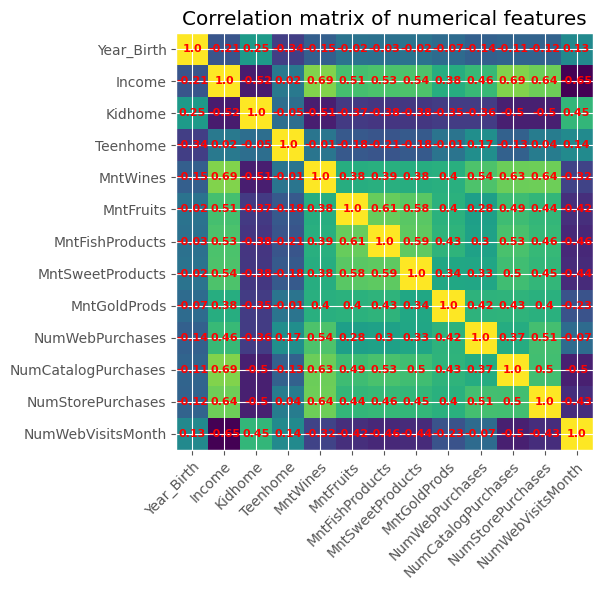

In [12]:
fig, ax = plt.subplots()
temp_df = workdf.copy()[features].select_dtypes(['number'])
temp_df.reset_index(drop=True, inplace=True)
im = ax.imshow(temp_df.corr())

cols = temp_df.columns

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=cols)
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i, col1 in enumerate(cols):
    for j, col2 in enumerate(cols):
        text = ax.text(j, i, temp_df.corr()[col2].loc[col1].round(2),
                       ha="center", va="center", color="red", fontsize=8, fontweight='bold')

ax.set_title("Correlation matrix of numerical features")
fig.tight_layout()
plt.show()

The correlation matrix gives us interesting patters, and a wider understanding of data distribution.
For example, the correlation ratio is high between: #CatalogPurchases, AmountofMeatProducts, and Income! Which is logical to our real-world cases.

In [13]:
# Extracting the categorical features
categorical_features = workdf.select_dtypes(include=['object', 'category']).columns
categorical_features

Index(['Education', 'Marital_Status', 'Dt_Customer'], dtype='object')

a. Education

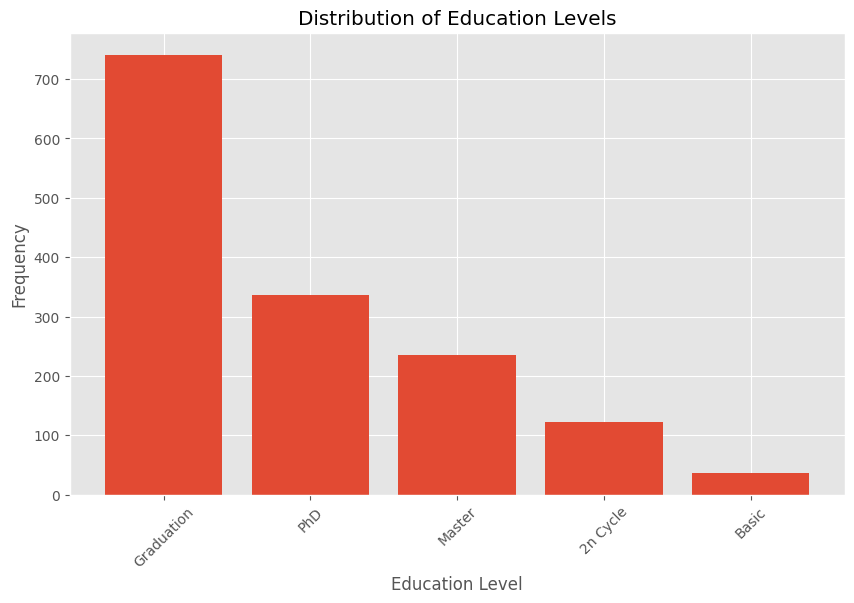

In [14]:
# Count the frequency of each category in the 'Education' column
education_counts = workdf['Education'].value_counts()

# Plotting
plt.bar(x=education_counts.index, height=education_counts.values)
plt.xlabel('Education Level')
plt.ylabel('Frequency')
plt.title('Distribution of Education Levels')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

In [15]:
education_levels = sorted(workdf['Education'].unique())
education_levels

['2n Cycle', 'Basic', 'Graduation', 'Master', 'PhD']

In [16]:
# The 'Education' column has 5 categories, but the 'Education' column is ordinal, so we can encode it as follows:
education_mapping = {
    'Basic': 1, 
    'Graduation': 2,       
    'Master': 3,   
    '2n Cycle': 4,     
    'PhD': 5
}

workdf['Education_ord'] = workdf['Education'].map(education_mapping)

In [17]:
# Let's check the result
workdf[['Education', 'Education_ord']].sample(n=8, random_state=rs)

Education  Education_ord
303   Graduation              2
1221  Graduation              2
1170       Basic              1
484       Master              3
839   Graduation              2
1243      Master              3
2052  Graduation              2
1044  Graduation              2

b. Marital_Status

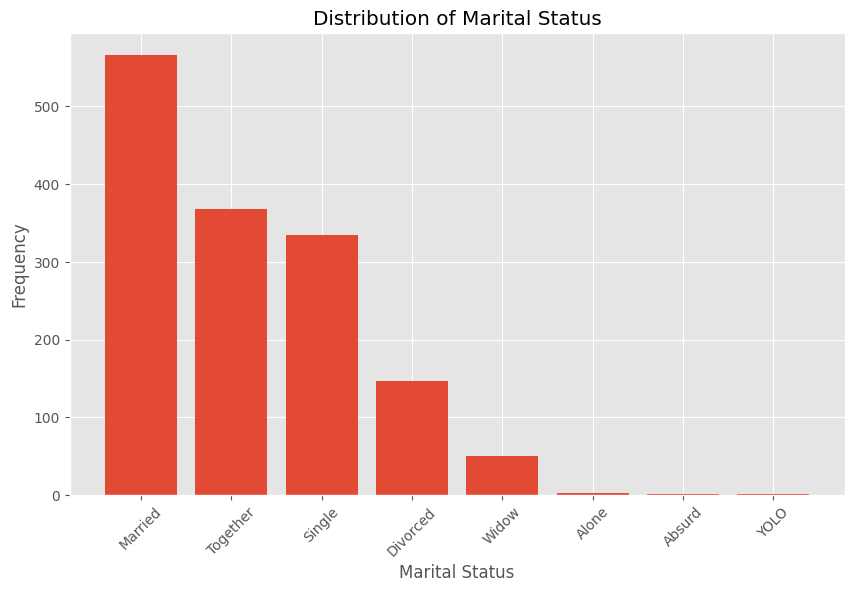

In [18]:
# Count the frequency of each category in the 'Education' column
martial_counts = workdf['Marital_Status'].value_counts()

# Plotting
plt.bar(x=martial_counts.index, height=martial_counts.values)
plt.xlabel('Marital Status')
plt.ylabel('Frequency')
plt.title('Distribution of Marital Status')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

It seems that we have to work on the distribution of Marital Status, since the categories: 'Alone', 'Absurd', and 'YOLO' are not very common and could be considered as outliers for the marital status.

In [19]:
#BEFORE
martial_counts

Marital_Status
Married     566
Together    368
Single      334
Divorced    147
Widow        50
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

As we can see we don't have a significant number of customers with these 3 categories, and therefore, we can drop these customers since they don't have any positive reflection for the use case of our study. Instead, the presence of these additional categories clearly affect the dimensionality reduction.

In [20]:
# Dropping rows where the 'Marital_Status' column is in ['Absurd', 'YOLO', 'Alone']
workdf = workdf[~workdf['Marital_Status'].isin(['Absurd', 'YOLO', 'Alone'])]

In [21]:
#AFTER
martial_counts = workdf['Marital_Status'].value_counts()
martial_counts

Marital_Status
Married     566
Together    368
Single      334
Divorced    147
Widow        50
Name: count, dtype: int64

Since `Marital_Status` is a nominal encoding we can encode it using One-Hot Encoding.

In [22]:
# One-hot encoding for the 'Marital_Status' column
marital_status_dummies = pd.get_dummies(workdf['Marital_Status'], prefix='Marital_Status', dtype=int)
workdf = pd.concat([workdf, marital_status_dummies], axis=1)

In [23]:
workdf[['Marital_Status'] + list(marital_status_dummies.columns)].sample(n=8, random_state=rs)

Marital_Status  Marital_Status_Divorced  Marital_Status_Married  \
50            Widow                        0                       0   
265         Married                        0                       1   
286        Together                        0                       0   
1096       Divorced                        1                       0   
962        Together                        0                       0   
2192        Married                        0                       1   
1729        Married                        0                       1   
644        Together                        0                       0   

      Marital_Status_Single  Marital_Status_Together  Marital_Status_Widow  
50                        0                        0                     1  
265                       0                        0                     0  
286                       0                        1                     0  
1096                      0                        0                     0  
962                       0                        1                     0  
2192                      0                        0                     0  
1729                      0                        0                     0  
644                       0                        1                     0

c. Dt_Customer

Is the date of customer’s enrollment with the company.\
Since we are preparing our data for PCA, we have to find a way to make this column numerical. Thus, an approach is to extract the year and subtract the current year from it, so we will get the number of years since the customer has enrolled.

In [24]:
# Dates don't seem to be well-distributed, we have close ranges, maybe data just collected for 3 years.
workdf['Dt_Customer'].min() , workdf['Dt_Customer'].max()

('01-01-2013', '31-12-2013')

Text(0.5, 1.0, 'Frequency of Dt_Customer by Year')

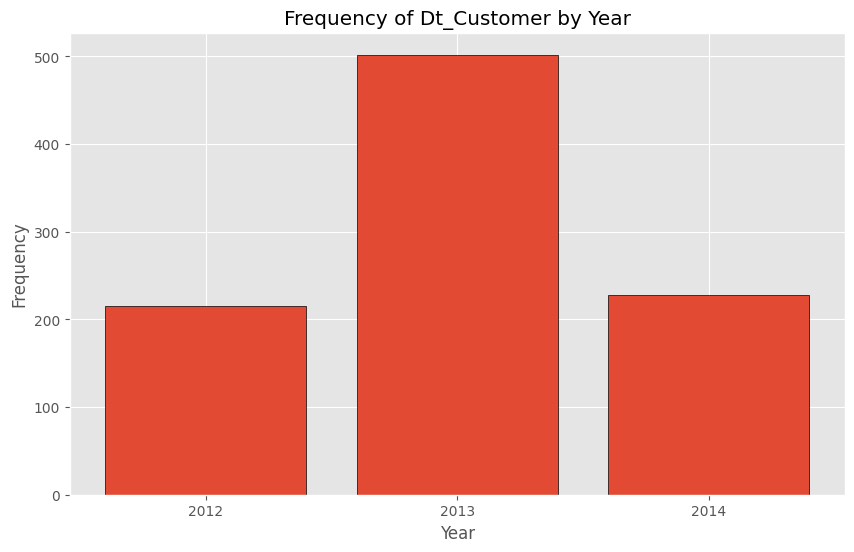

In [25]:
# Convert Dt_Customer column to datetime
workdf['Dt_Customer'] = pd.to_datetime(workdf['Dt_Customer'], format='%d-%m-%Y')

# Extract the year from Dt_Customer column
temp_df['Year'] = workdf['Dt_Customer'].dt.year

# Count the frequency of each year
year_counts = temp_df['Year'].value_counts()

# Plot the frequency
plt.bar(x=year_counts.index, height=year_counts.values, edgecolor='black', bottom=0)

plt.xticks(year_counts.index)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Dt_Customer by Year')


Our data is distributed in a small range of years (3 consecutive years), and therefore if we replace the Date of enrolment of the customer with for how many years he has been a customer, we will get close values which may not lead to understand the effect of Enrolment Date to our study.

Thus, another approach, is to transform each date of enrolment to number of months since he has been enrolled!

In [26]:
# Ensure Dt_Customer is in datetime format
workdf['Dt_Customer'] = pd.to_datetime(workdf['Dt_Customer'])

# Choose a reference date. Here, we use the current date
reference_date = pd.to_datetime('today')

# Calculate the difference in months
workdf['NumMonthsSince'] = ((reference_date.year - workdf['Dt_Customer'].dt.year) * 12 +
                          (reference_date.month - workdf['Dt_Customer'].dt.month))


workdf[['NumMonthsSince', 'Dt_Customer']].sample(n=8, random_state=rs)

NumMonthsSince Dt_Customer
50               115  2014-05-12
265              129  2013-03-14
286              131  2013-01-29
1096             114  2014-06-02
962              132  2012-12-30
2192             136  2012-08-02
1729             130  2013-02-17
644              129  2013-03-10

In [27]:
# Discard Old columns
features = [col for col in workdf.columns if col not in labels + ['ID', 'Z_CostContact', 'Z_Revenue'] + ['Education',
 'Marital_Status', 'Dt_Customer']]
features

['Year_Birth',
 'Income',
 'Kidhome',
 'Teenhome',
 'MntWines',
 'MntFruits',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Education_ord',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Marital_Status_Together',
 'Marital_Status_Widow',
 'NumMonthsSince']

Additional Study for the data distribution:

The goal here is to check the distribution of some column, maybe we can remove outliers where this is helpful for PCA because we know that it is sensitive to outliers.

Here, the boxplot will help us to find outliers.

_Note:_ Values above $Q_{3} + 1.5 \times IQR$ or below $Q_{1} - 1.5 \times IQR$  are considered as outliers. where $IQR = Q_{3} - Q_{1}$

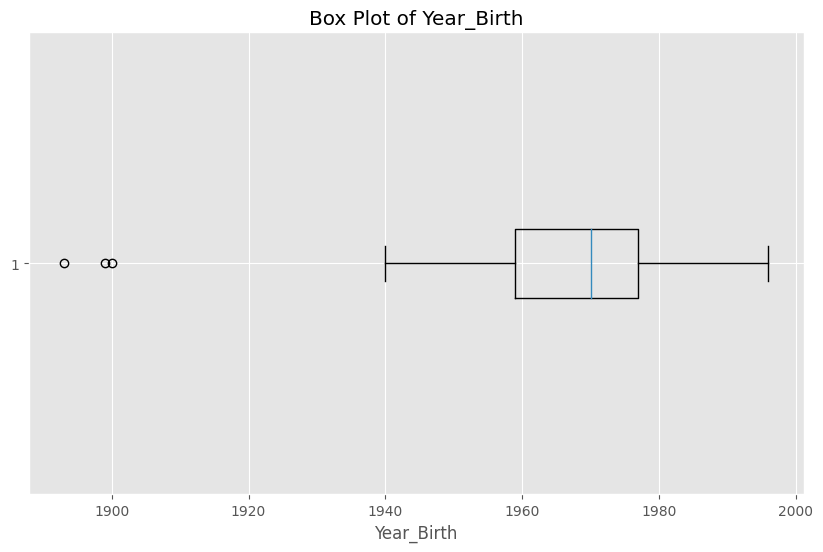

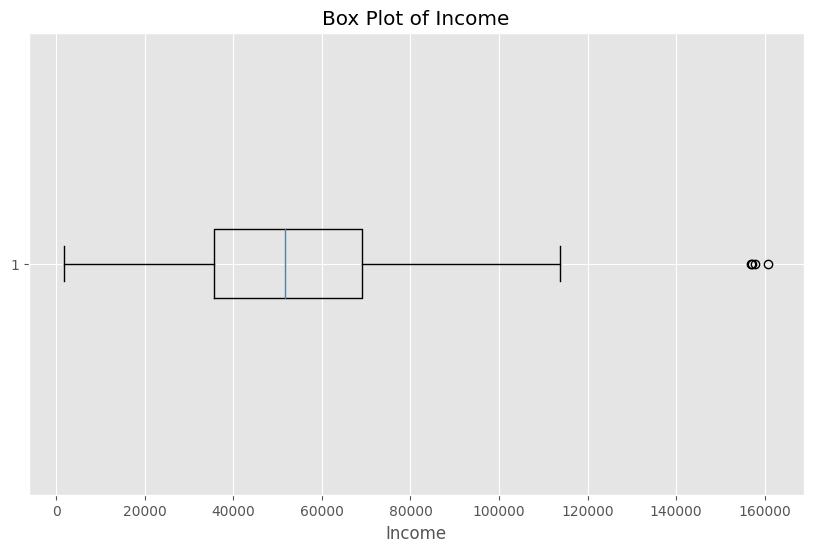

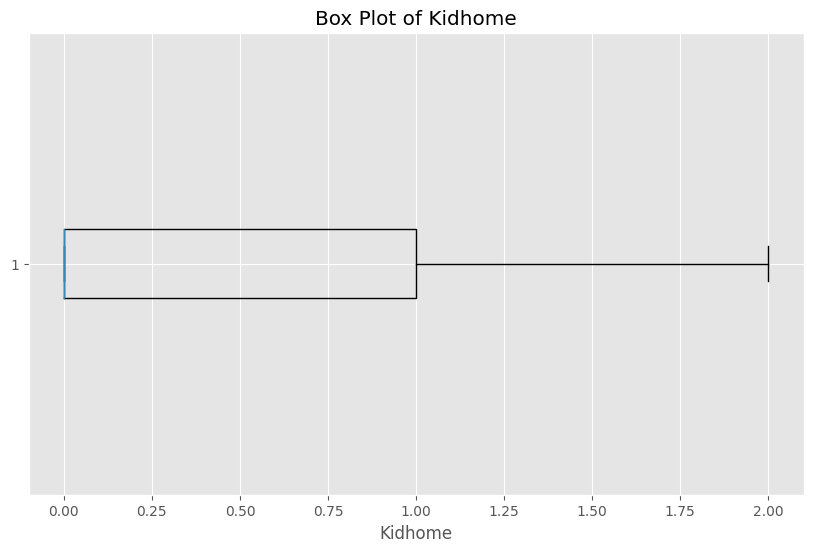

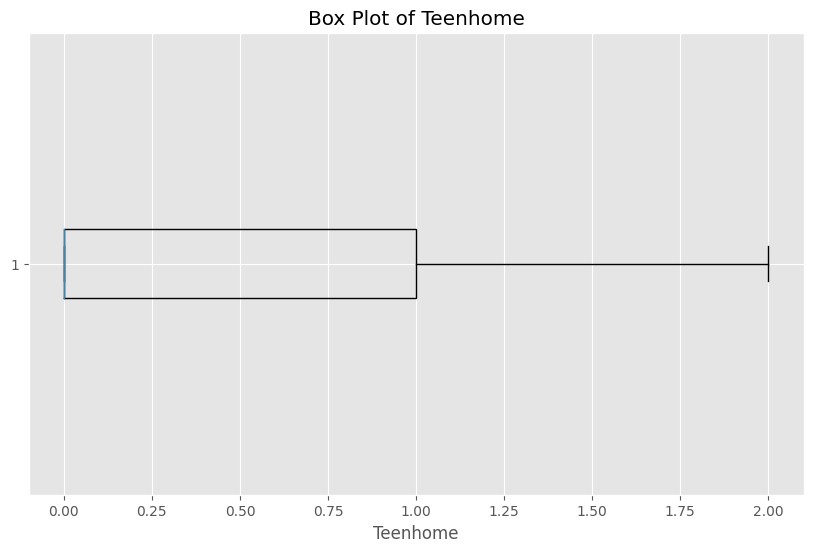

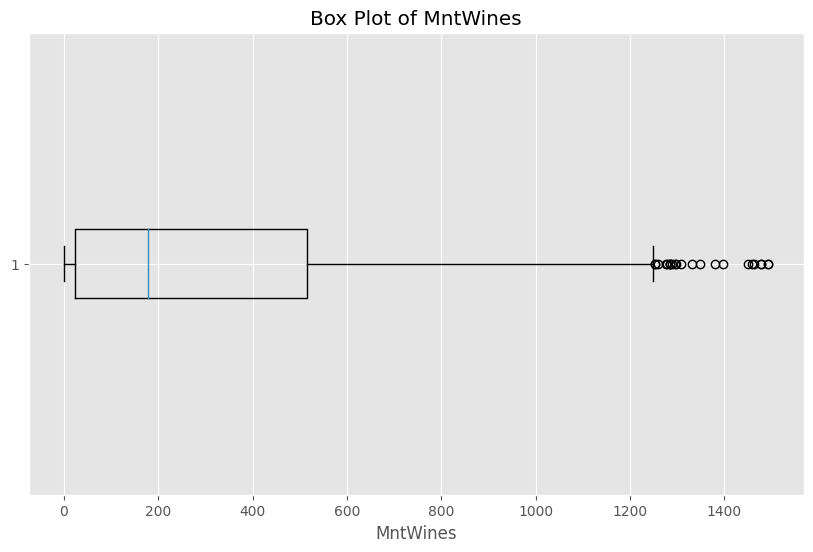

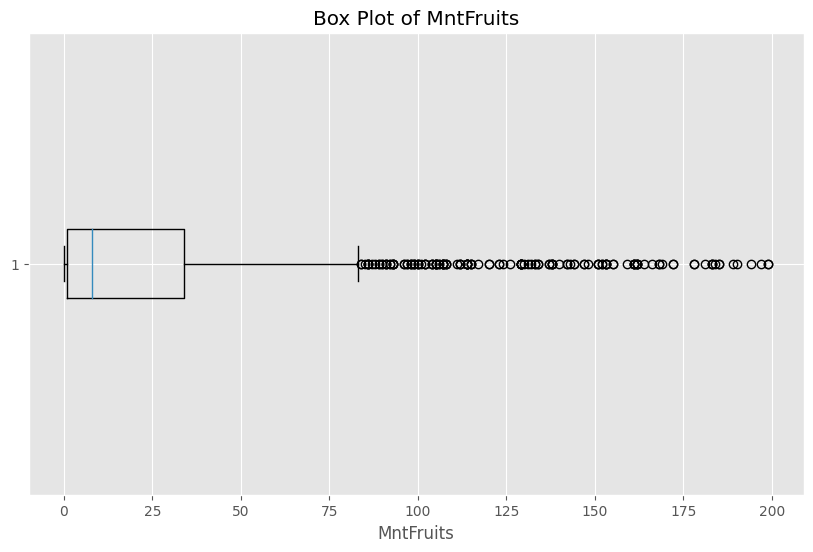

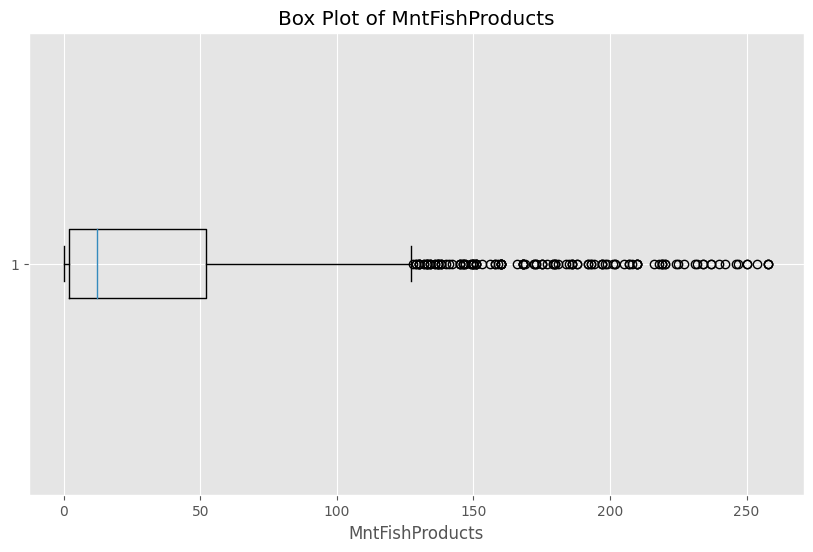

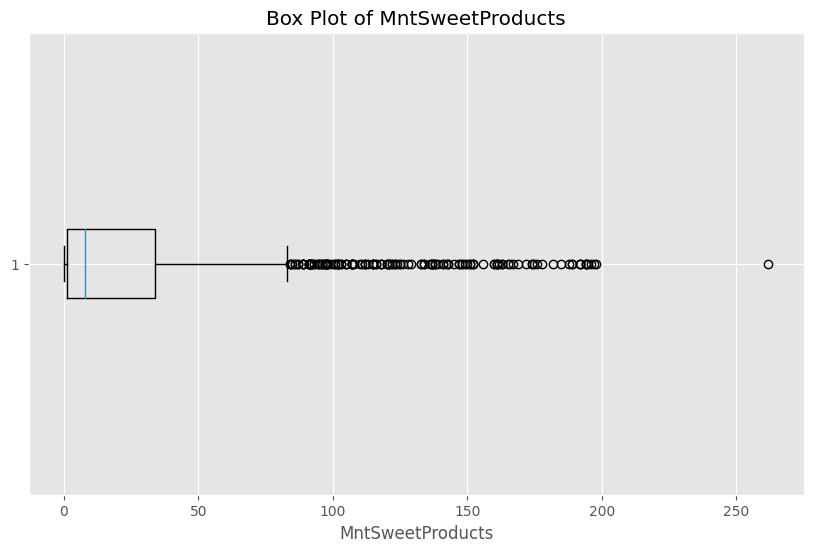

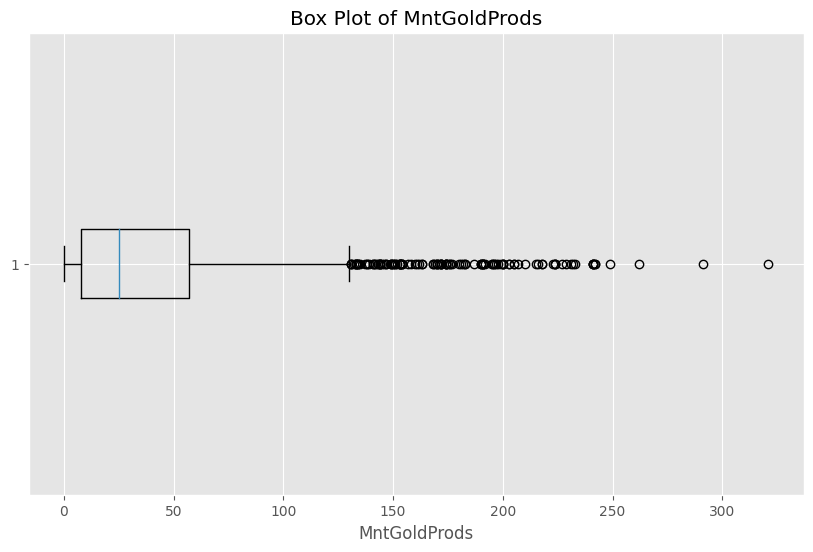

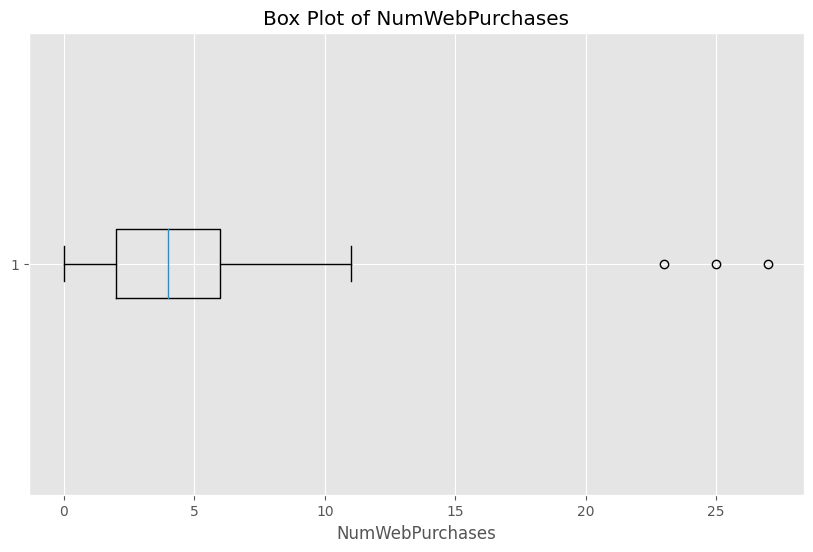

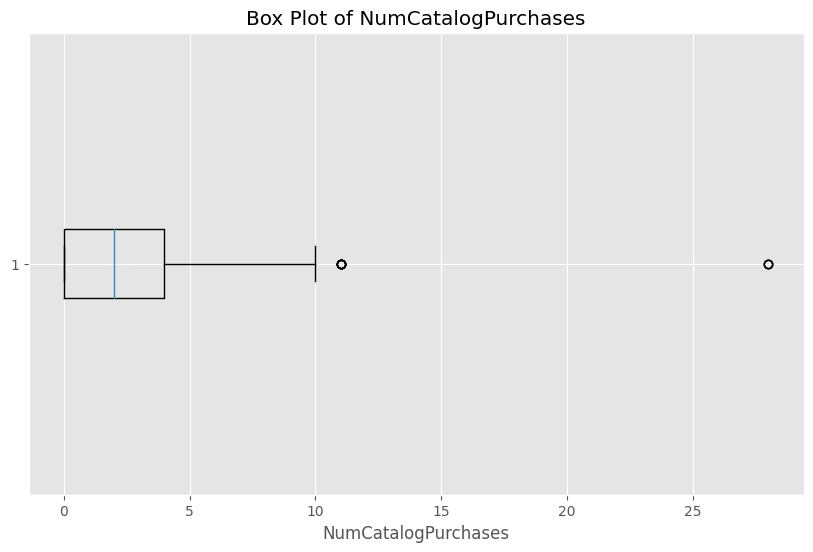

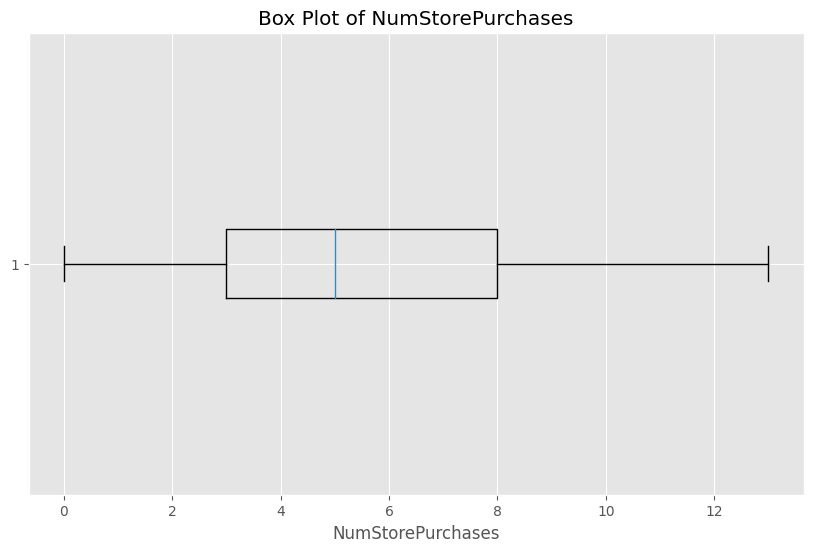

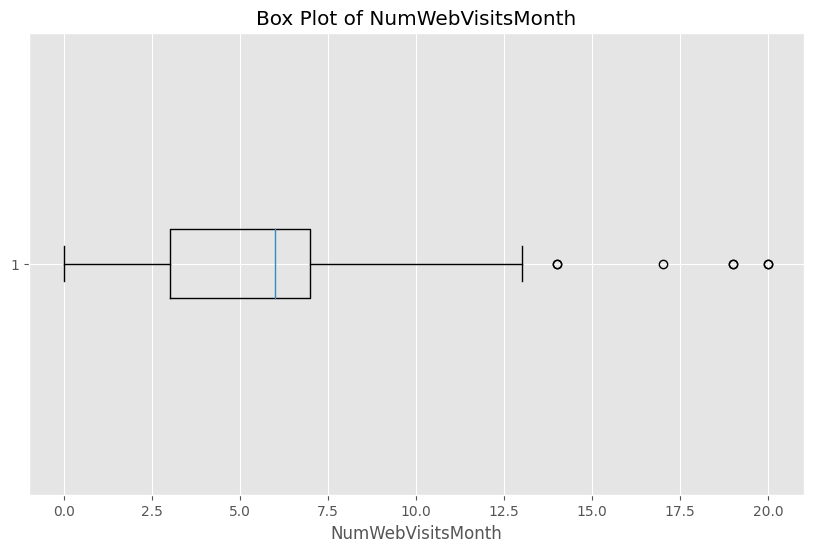

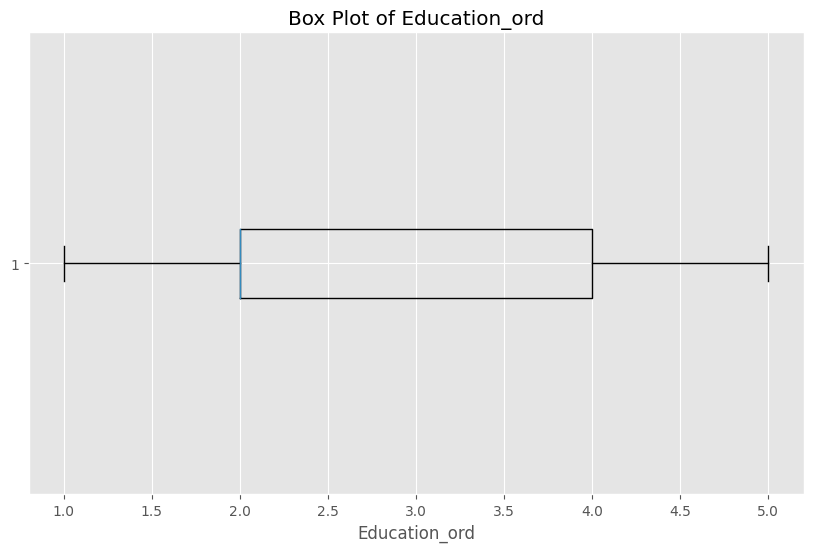

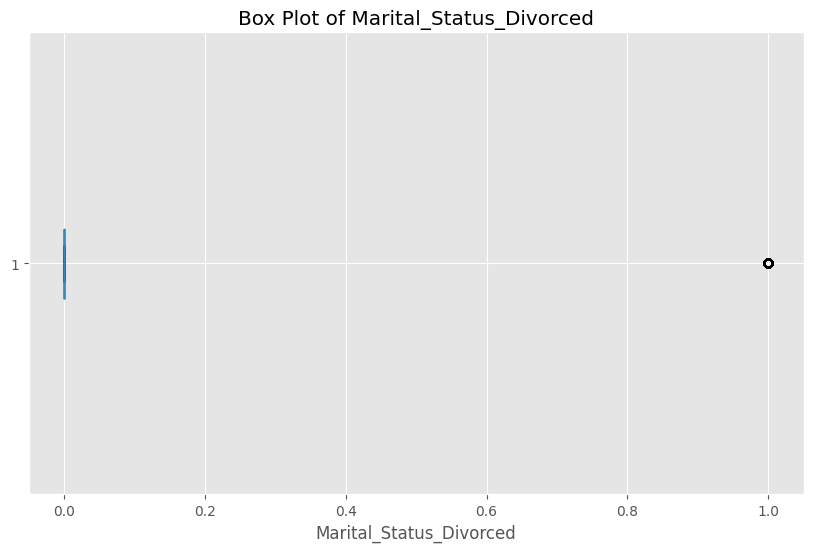

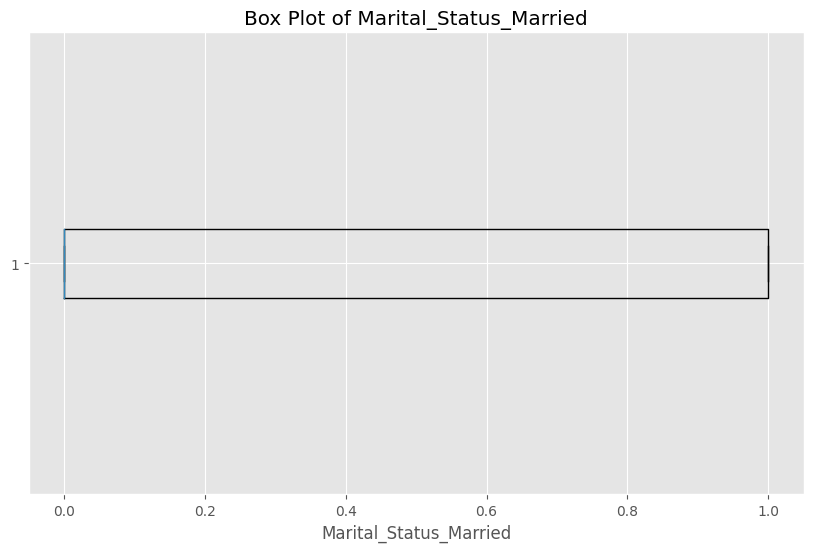

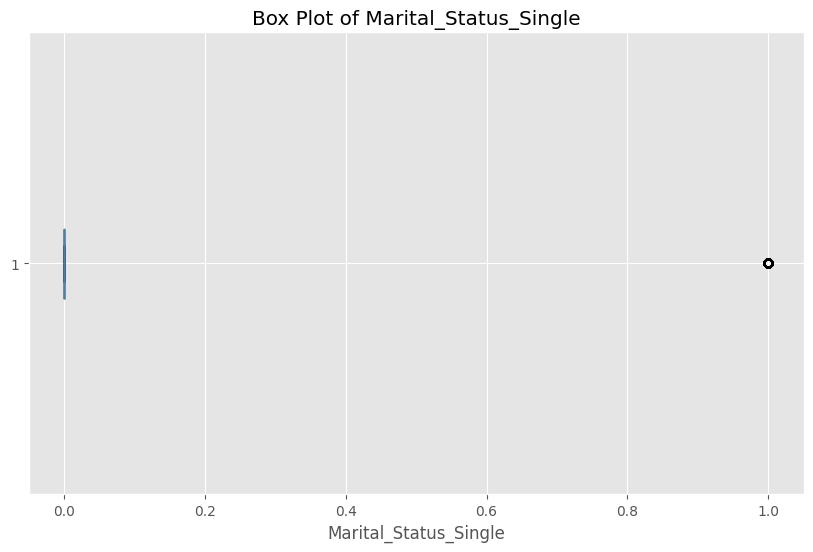

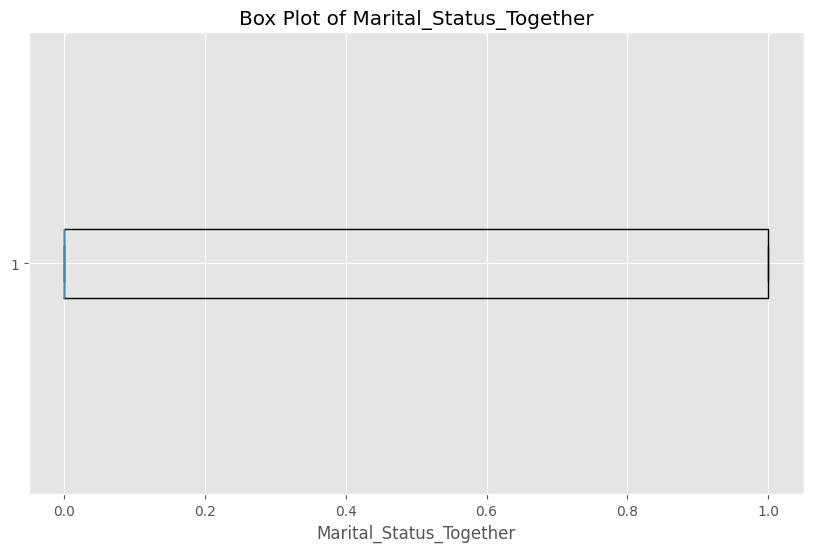

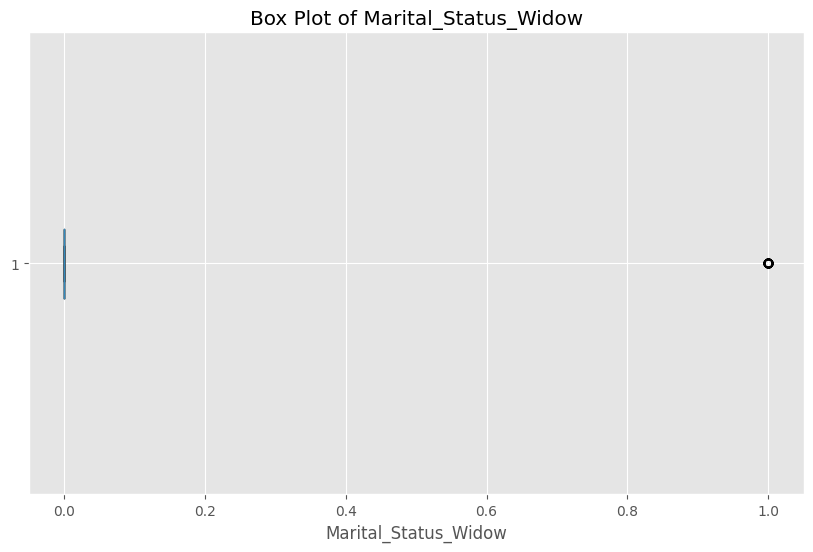

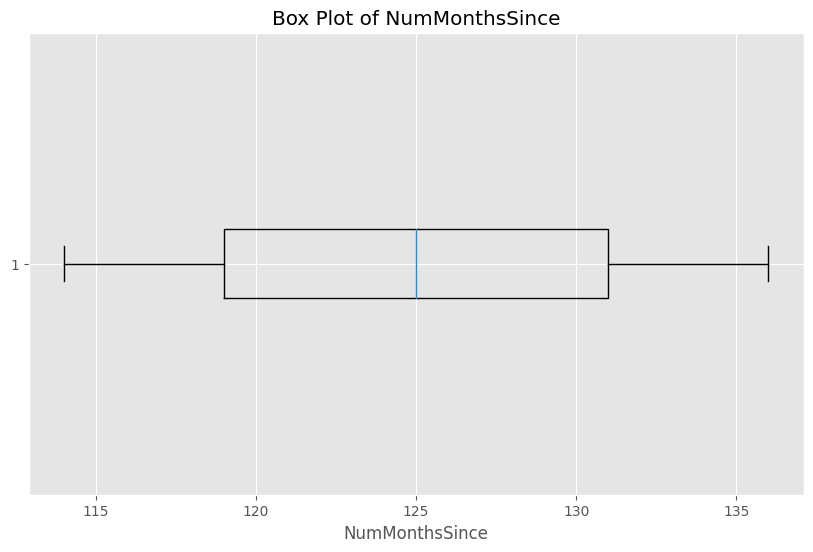

In [28]:
for column in workdf[features].columns:
    plt.boxplot(workdf[column], vert=False, showfliers=True)
    plt.xlabel(column)
    plt.title(f'Box Plot of {column}')
    plt.grid(True)
    plt.show()

Now we can using these graphs, remove outliers. This work is done only on non-categorical features.

- Year_Birth: Remove data with less than 1910.
A comment here, that we have to be realistic, if this work is for a company, I cannot tell my manager I did my study on people aged more than 100 years! The targeted customers must rely to an accessible range of ages.
- Income: It seems that we have outliers for people with income greater than 130K. And this is reasonable because these customers are rare.
- For other columns we will keep other information since the amount of spent product is important for our study.

In [29]:
# Number of customers older than 1910
cust_1910 = len(workdf[workdf['Year_Birth'] <= 1910])
print(f"Number of customers older than 1910: {cust_1910}, which is {cust_1910 / len(workdf) * 100:.2f}% of the total")

# Remove customers older than 1910
workdf = workdf[workdf['Year_Birth'] > 1910]

Number of customers older than 1910: 3, which is 0.20% of the total


In [30]:
# Number of customers with income higher than 130K
cust_130K = len(workdf[workdf['Income'] >= 130_000])
print(f"Number of customers with income higher than 130K: {cust_130K}, which is {cust_130K / len(workdf) * 100:.2f}% of the total")

# Remove customers income outliers
workdf = workdf[workdf['Income'] < 130_000]

Number of customers with income higher than 130K: 4, which is 0.27% of the total


In [31]:
# Store into the new variable
Xworkdf = workdf[features].copy()
Xworkdf.head()

Year_Birth   Income  Kidhome  Teenhome  MntWines  MntFruits  \
1636        1954  50002.0        0         1       443          5   
1319        1984  37235.0        1         0        20          2   
948         1977  39771.0        1         0         6          2   
1597        1984  36108.0        1         0       141          8   
265         1966  38179.0        1         1        38          4   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumWebPurchases  \
1636               21                16            82                8   
1319                4                 6            20                1   
948                 2                 8            14                2   
1597                3                11            47                7   
265                 4                 2            20                3   

      NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
1636                    2                  7                  7   
1319                    1                  2                  4   
948                     0                  3                  4   
1597                    1                  4                  9   
265                     1                  3                  7   

      Education_ord  Marital_Status_Divorced  Marital_Status_Married  \
1636              2                        1                       0   
1319              2                        0                       0   
948               2                        0                       0   
1597              2                        0                       0   
265               3                        0                       1   

      Marital_Status_Single  Marital_Status_Together  Marital_Status_Widow  \
1636                      0                        0                     0   
1319                      0                        1                     0   
948                       0                        1                     0   
1597                      1                        0                     0   
265                       0                        0                     0   

      NumMonthsSince  
1636             126  
1319             118  
948              120  
1597             122  
265              129

#### Exercise 3 (Preprocessing and full-PCA)

##### 3.1 Scaling

In [32]:
# StandardScaler
stdScaler = StandardScaler()
Xworkdf_std = stdScaler.fit_transform(Xworkdf)
# Convert the numpy array back to a DataFrame
Xworkdf_std = pd.DataFrame(Xworkdf_std, columns=Xworkdf.columns)  

# MinMaxScaler
mmScaler = MinMaxScaler(feature_range=(0, 1))
Xworkdf_mm = mmScaler.fit_transform(Xworkdf)
Xworkdf_mm = pd.DataFrame(Xworkdf_mm, columns=Xworkdf.columns)

In [33]:
Xworkdf_std.sample(n=8, random_state=rs)

Year_Birth    Income   Kidhome  Teenhome  MntWines  MntFruits  \
372     1.636732 -0.573747  1.057293 -0.924836 -0.676988  -0.291997   
854    -0.078528  0.225432 -0.818051  0.919775  1.111085  -0.490879   
616     0.693339 -1.260811  1.057293 -0.924836 -0.908179  -0.441158   
1310   -1.450736  1.117778 -0.818051 -0.924836 -0.021459   1.771403   
1044    0.350287 -0.588600  1.057293 -0.924836 -0.703326  -0.664901   
1419    0.693339  0.293034  1.057293  0.919775  0.423364  -0.565460   
438    -0.335817  0.398103 -0.818051  0.919775  0.797952   0.428950   
679    -1.021921 -2.140589 -0.818051  0.919775 -0.597973  -0.615180   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumWebPurchases  \
372         -0.323053         -0.343562      0.156401         0.316664   
854         -0.505942         -0.657539      0.040393         2.111747   
616         -0.487653         -0.585083     -0.423638        -0.401370   
1310         2.054500          1.129713      0.581763         0.675680   
1044        -0.688831         -0.657539     -0.597650        -0.401370   
1419        -0.688831         -0.657539     -0.674989         1.393714   
438          0.152457         -0.464322      2.573232         2.470764   
679         -0.652253         -0.609235     -0.616985        -1.478420   

      NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
372             -0.590382          -0.567020           1.095639   
854              0.474058           0.359098           1.095639   
616             -0.945195          -0.875726           1.095639   
1310             0.119244           2.211335          -0.937764   
1044            -0.590382          -1.184432           0.688958   
1419            -0.235569           0.050392           0.688958   
438              0.474058           0.667804           1.095639   
679             -0.945195          -1.493138           5.975808   

      Education_ord  Marital_Status_Divorced  Marital_Status_Married  \
372       -0.774464                -0.333587               -0.794275   
854       -0.774464                -0.333587               -0.794275   
616        0.809223                -0.333587               -0.794275   
1310      -0.774464                -0.333587               -0.794275   
1044       1.601067                -0.333587               -0.794275   
1419       0.017379                -0.333587               -0.794275   
438        0.809223                 2.997716               -0.794275   
679        1.601067                -0.333587               -0.794275   

      Marital_Status_Single  Marital_Status_Together  Marital_Status_Widow  \
372                1.838037                -0.577878             -0.188445   
854               -0.544059                 1.730468             -0.188445   
616               -0.544059                 1.730468             -0.188445   
1310              -0.544059                 1.730468             -0.188445   
1044              -0.544059                 1.730468             -0.188445   
1419              -0.544059                 1.730468             -0.188445   
438               -0.544059                -0.577878             -0.188445   
679               -0.544059                 1.730468             -0.188445   

      NumMonthsSince  
372        -1.363348  
854        -0.013578  
616        -0.613476  
1310        0.886269  
1044       -0.163552  
1419       -1.663297  
438         1.336192  
679         1.036243

In [34]:
Xworkdf_mm.sample(n=8, random_state=rs)

Year_Birth    Income  Kidhome  Teenhome  MntWines  MntFruits  \
372     0.857143  0.339425      0.5       0.0  0.053583   0.075377   
854     0.500000  0.489304      0.0       0.5  0.462827   0.035176   
616     0.660714  0.210573      0.5       0.0  0.000670   0.045226   
1310    0.214286  0.656655      0.0       0.0  0.203617   0.492462   
1044    0.589286  0.336640      0.5       0.0  0.047555   0.000000   
1419    0.660714  0.501982      0.5       0.5  0.305425   0.020101   
438     0.446429  0.521687      0.0       0.5  0.391159   0.221106   
679     0.303571  0.045579      0.0       0.5  0.071668   0.010050   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumWebPurchases  \
372          0.077519          0.049618      0.161994         0.185185   
854          0.038760          0.000000      0.143302         0.370370   
616          0.042636          0.011450      0.068536         0.111111   
1310         0.581395          0.282443      0.230530         0.222222   
1044         0.000000          0.000000      0.040498         0.111111   
1419         0.000000          0.000000      0.028037         0.296296   
438          0.178295          0.030534      0.551402         0.407407   
679          0.007752          0.007634      0.037383         0.000000   

      NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
372              0.035714           0.307692               0.40   
854              0.142857           0.538462               0.40   
616              0.000000           0.230769               0.40   
1310             0.107143           1.000000               0.15   
1044             0.035714           0.153846               0.35   
1419             0.071429           0.461538               0.35   
438              0.142857           0.615385               0.40   
679              0.000000           0.076923               1.00   

      Education_ord  Marital_Status_Divorced  Marital_Status_Married  \
372            0.25                      0.0                     0.0   
854            0.25                      0.0                     0.0   
616            0.75                      0.0                     0.0   
1310           0.25                      0.0                     0.0   
1044           1.00                      0.0                     0.0   
1419           0.50                      0.0                     0.0   
438            0.75                      1.0                     0.0   
679            1.00                      0.0                     0.0   

      Marital_Status_Single  Marital_Status_Together  Marital_Status_Widow  \
372                     1.0                      0.0                   0.0   
854                     0.0                      1.0                   0.0   
616                     0.0                      1.0                   0.0   
1310                    0.0                      1.0                   0.0   
1044                    0.0                      1.0                   0.0   
1419                    0.0                      1.0                   0.0   
438                     0.0                      0.0                   0.0   
679                     0.0                      1.0                   0.0   

      NumMonthsSince  
372         0.090909  
854         0.500000  
616         0.318182  
1310        0.772727  
1044        0.454545  
1419        0.000000  
438         0.909091  
679         0.818182

##### 3.2 Analyzing Variances

In [35]:
# Extracting only the numerical features (excluding categorical features)
categorical_features
noncat_features = [col for col in Xworkdf.columns if col not in ['Education_ord', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow']]

noncat_features

['Year_Birth',
 'Income',
 'Kidhome',
 'Teenhome',
 'MntWines',
 'MntFruits',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'NumMonthsSince']

In [36]:
def rounder(x):
    return round(x, 2)

# Calculate variances
var_original = rounder(Xworkdf[noncat_features].var())
var_std_scaled = rounder(Xworkdf_std[noncat_features].var())
var_minmax_scaled = rounder(Xworkdf_mm[noncat_features].var())

# Create a DataFrame for easier comparison
var_comparison = pd.DataFrame({
    'Original': var_original,
    'Standard Scaled': var_std_scaled,
    'MinMax Scaled': var_minmax_scaled
})

var_comparison

Original  Standard Scaled  MinMax Scaled
Year_Birth           1.360500e+02              1.0           0.04
Income               4.415258e+08              1.0           0.04
Kidhome              2.800000e-01              1.0           0.07
Teenhome             2.900000e-01              1.0           0.07
MntWines             1.168450e+05              1.0           0.05
MntFruits            1.619150e+03              1.0           0.04
MntFishProducts      2.991740e+03              1.0           0.04
MntSweetProducts     1.715500e+03              1.0           0.02
MntGoldProds         2.676860e+03              1.0           0.03
NumWebPurchases      7.760000e+00              1.0           0.01
NumCatalogPurchases  7.950000e+00              1.0           0.01
NumStorePurchases    1.050000e+01              1.0           0.06
NumWebVisitsMonth    6.050000e+00              1.0           0.02
NumMonthsSince       4.449000e+01              1.0           0.09

The variance between the original data and Scaled data (some terms are time e8 and others are decimals) is not proportional, this will affect plotting variances of original data with scaled data.

First, we present here a graph for the comparaison of feature variance for both scaled dataframes.

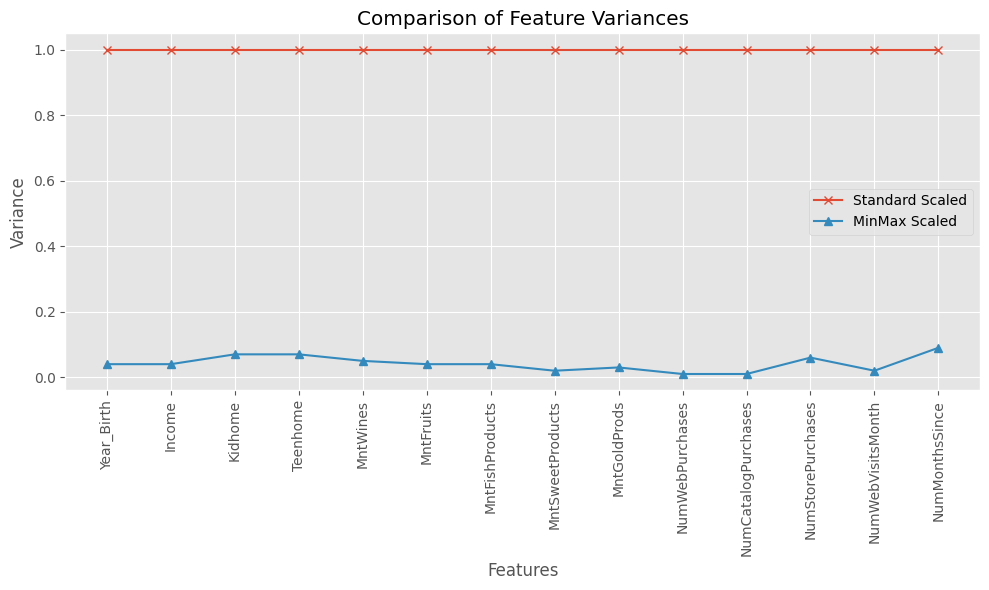

In [37]:
# Plot for Standard Scaled DataFrame
plt.plot(var_std_scaled.index, var_std_scaled, label='Standard Scaled', marker='x')

# Plot for MinMax Scaled DataFrame
plt.plot(var_minmax_scaled.index, var_minmax_scaled, label='MinMax Scaled', marker='^')

plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Comparison of Feature Variances')
plt.xticks(rotation=90)  # Rotate feature names for better visibility
plt.legend()
plt.tight_layout()
plt.show()


It is obvious to have Standarized data with a unit variance (i.e. equal to 1) because Standard Scaler transform the data into a Normal Gaussian Distribution

Text(0.5, 1.0, 'Original Feature Variances - Log Scale')

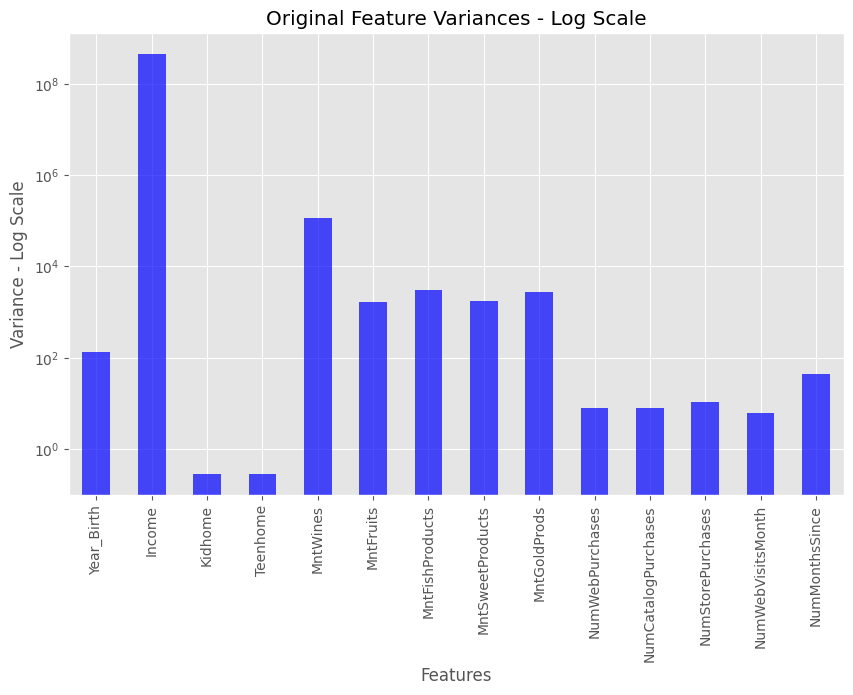

In [38]:
var_original.plot(kind='bar', logy=True, label='Original', color='blue' , alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Variance - Log Scale')
plt.title('Original Feature Variances - Log Scale')

**Observations:**
1. Xworkdf:
- Numerical features exhibit high variances, which is expected given the wide range of values and high coefficient of variation observed in previous analysis. This indicates that the numerical features have significant variation and contribute to the overall variability in the dataset.



2. Xworkdf_std:
- The application of the Standard Scaler results in a variance of 1 for all features, as intended. This scaling behavior ensures that all numerical features have equal variances, allowing for a fair comparison of their
influence on the principal components.

3. Xworkdf_mm:
- The variance decreases significantly due to the MinMax scaler, which divides by the range (always larger than the standard deviation). Consequently, the variance, being the squared standard deviation, tends to
approach zero. This indicates that the numerical features, after scaling with MinMax, have a reduced range of values and, therefore, reduced variability.

Finally, based on this analysis, we can infer that scaling the non-categorical features using either a `StandardScaler` or a `MinMaxScaler` can help to have comparable variances. This could be particularly important for certain machine learning algorithms, such as those that rely on distance-based calculations or regularization.

##### 3.3 Full PCA

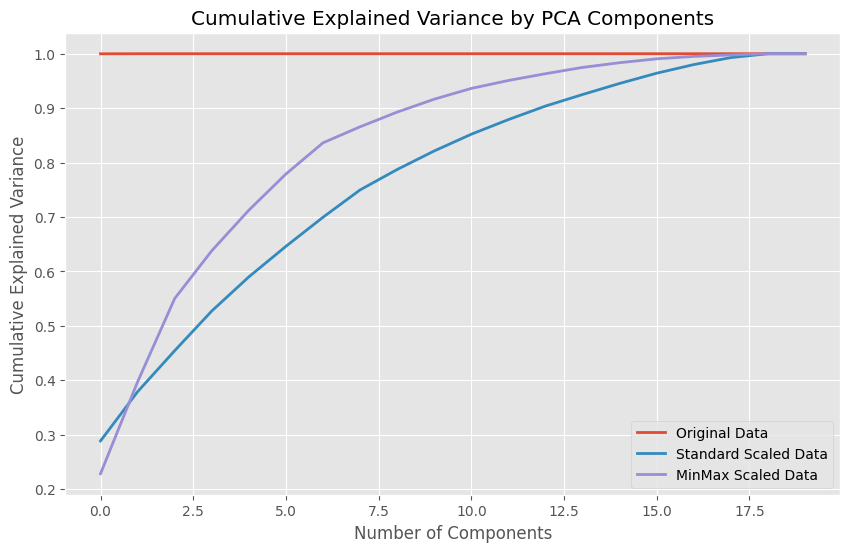

In [40]:
def apply_pca(data, rs):
    pca = PCA(random_state=rs, svd_solver='full')
    pca.fit(data)
    return pca.explained_variance_ratio_.cumsum()

# Apply PCA to the original, standard scaled, and MinMax scaled DataFrames
cumulative_variance_original = apply_pca(Xworkdf, rs)
cumulative_variance_std = apply_pca(Xworkdf_std, rs)
cumulative_variance_mm = apply_pca(Xworkdf_mm, rs)

plt.plot(cumulative_variance_original, label='Original Data', linewidth=2)
plt.plot(cumulative_variance_std, label='Standard Scaled Data', linewidth=2)
plt.plot(cumulative_variance_mm, label='MinMax Scaled Data', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.legend(loc='best')
plt.show()

**Observations:**

- `Xworkdf`: It has a constant cumulative explained variance of 1, which means that all of the variance in the data are explained by the full set of features. Which was expected (the cumulative explained variance will always reach 1 if all components are included). The fact that the original dataset's variance is much larger in magnitude due to the lack of scaling, which is why it appears as a flat line at the top of the graph.

- `Xworkdf_mm`: Comparing with the cumulative explained variance of the original dataset, it has a slower increase, where it reaches a cumulative variance of around 0.9 in around 8 PCs and then 1 for 16 PCs.
This indicates that standardizing the dataset has reduced the impact of
features with large variances, but there are still a large number of principal components required to explain the majority of the variance in the data.

- `Xworkdf_std`: Same as min-max scaled data, it is still under the performance of the original data but also it is slower than the MinMax Scaled data. The curve shows a slow convergence where we can clearly see that it reaches 0.9 cumulative variance in 12 PCs so it is kind of 1.5 slower than min-max. Finally, if we focus on the graph, we can notice that even after 17.5 PCs (17 PCs) the cumulative variance didn't arrive yet to 1 (zoom in). This means that the majority of the variance in the data can be explained by a smaller number of principal components.

The scaled data's cumulative variance rises more gradually, indicating that a small number of features in the original data were much more variable than others. By scaling the data, we reduce the overly large influence of these few features, meaning we need more components to describe the data's spread. This balanced approach is one of the main goals of PCA.

Finally, after scaling, the principal components are more interpretable because they don't disproportionately represent the features with originally high variances.

#### Exercise 4 (Dimensionality Reduction and Interpretation of the PCs)

##### 4.1

In [43]:
# Apply PCA to the standardized data
pca_std = PCA().fit(Xworkdf_std)
cumulative_variance_std = pca_std.explained_variance_ratio_.cumsum()

# Find m for the standardized data
m_std = np.argmax(cumulative_variance_std >= 0.33) + 1
m_std = min(m_std, 5)

# Apply PCA to the MinMax scaled data
pca_mm = PCA().fit(Xworkdf_mm)
cumulative_variance_mm = pca_mm.explained_variance_ratio_.cumsum()

# Find m1 for the MinMax scaled data
m_mm = np.argmax(cumulative_variance_mm >= 0.33) + 1
m_mm = min(m_mm, 5)

print(f"m for standardized data: {m_std}, m for MinMax scaled data: {m_mm}")

m for standardized data: 2, m for MinMax scaled data: 2


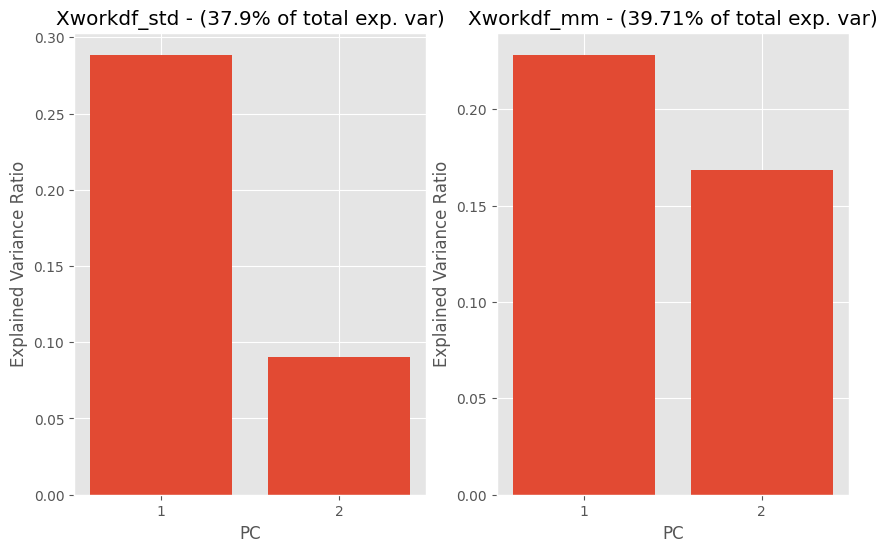

In [49]:
# plot barplots of percentage of explained variance
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].bar(range(1, m_std+1), pca_std.explained_variance_ratio_[:m_std])
round_expl_var_ratio = np.round(pca_std.explained_variance_ratio_[:m_std].sum() * 100, decimals=2)
axs[0].set_title(f"Xworkdf_std - ({round_expl_var_ratio}% of total exp. var)")
axs[0].set_xlabel('PC')
axs[0].set_ylabel('Explained Variance Ratio')
axs[0].set_xticks(range(1, m_std+1))  # Set x-axis ticks as integers

axs[1].bar(range(1, m_mm+1), pca_mm.explained_variance_ratio_[:m_mm])
round_expl_var_ratio2 = np.round(pca_mm.explained_variance_ratio_[:m_mm].sum() * 100, decimals=2)
axs[1].set_title(f"Xworkdf_mm - ({round_expl_var_ratio2}% of total exp. var)")
axs[1].set_xlabel('PC')
axs[1].set_ylabel('Explained Variance Ratio')
axs[1].set_xticks(range(1, m_mm+1))  # Set x-axis ticks as integers

plt.show()

In [50]:
pca_std = PCA(n_components=m_std, random_state=rs).fit(Xworkdf_std)

In [51]:
pca_mm = PCA(n_components=m_mm, random_state=rs).fit(Xworkdf_mm)

##### 4.2.a PCA_STD

PC1:
	Income: 0.36
	MntWines: 0.32
	MntFruits: 0.28
	MntMeatProducts: 0.33
	Kidhome: -0.28
	NumWebVisitsMonth: -0.26


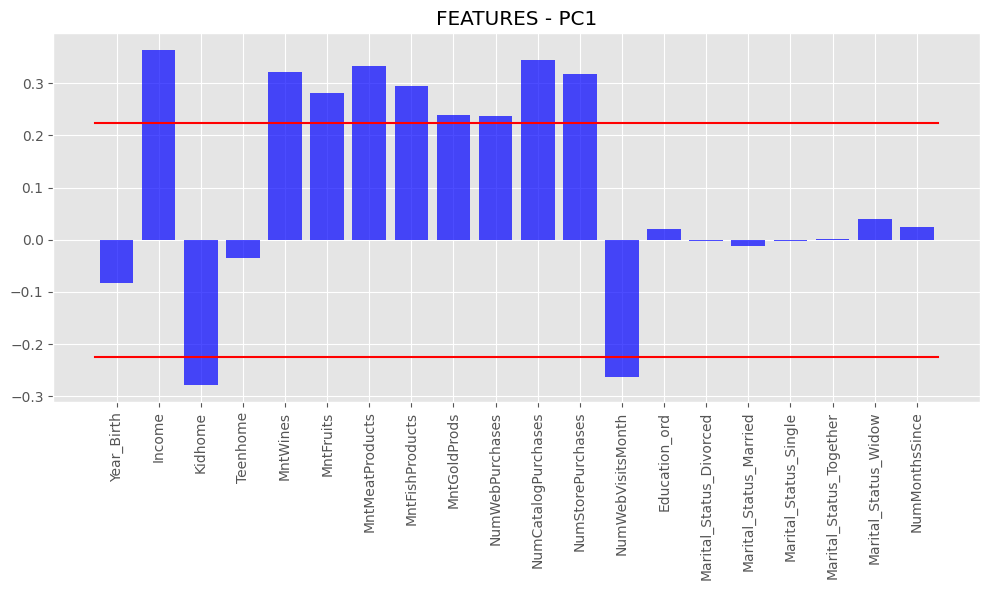


PC2:
	Teenhome: 0.55
	NumWebPurchases: 0.26
	Education_ord: 0.28
	Year_Birth: -0.46
	Marital_Status_Single: -0.30


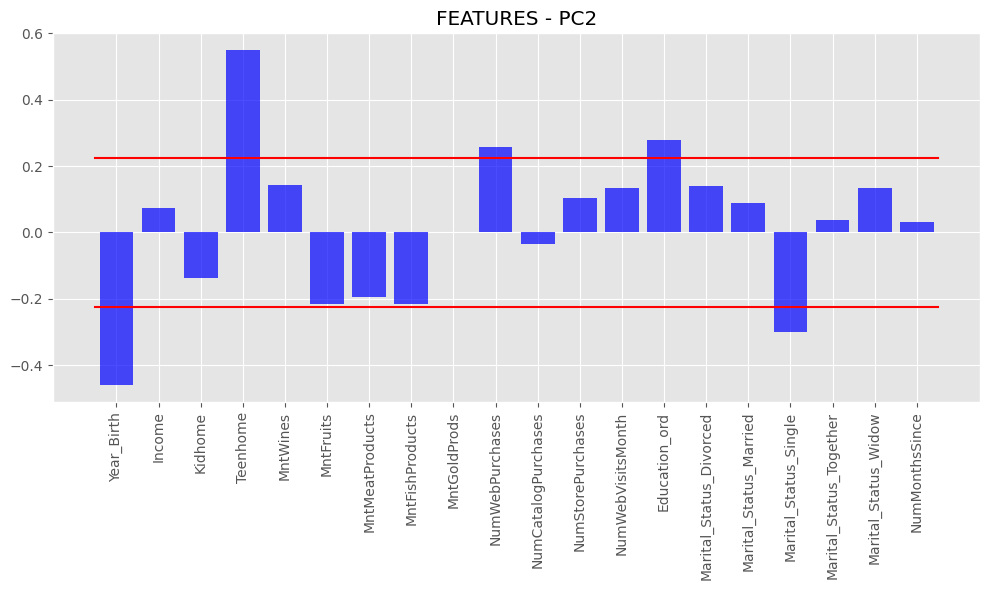

In [44]:
# Get the names of the original features
feature_names = Xworkdf.columns.tolist()
# Get the loadings for each principal component
loadings = pca_std.components_
# Get the threshold
eps_std = np.sqrt(1 / pca_std.n_features_in_)
# Loop through each principal component and print the top 5 features with the highest positive and negative loadings
for i, pc in enumerate(loadings):
    print(f"PC{i+1}:")
    # Top 3 features for each is enough
    top_pos = [j for j in range(len(pc)) if pc[j] > eps_std][:4]
    top_neg = [j for j in range(len(pc)) if pc[j] < -eps_std][:4]
    for j in range(len(top_pos)):
        print(f"\t{feature_names[top_pos[j]]}: {pc[top_pos[j]]:.2f}")
    for j in range(len(top_neg)):
        print(f"\t{feature_names[top_neg[j]]}: {pc[top_neg[j]]:.2f}")
        
    plt.bar(Xworkdf.columns, pca_std.components_[i, :], color='blue', alpha=0.7)
    plt.plot([-0.5, pca_std.n_features_in_ - 0.5], [eps_std, eps_std], 'red')
    plt.plot([-0.5, pca_std.n_features_in_ - 0.5], [-eps_std, -eps_std], 'red')
    
    plt.xticks(ticks=np.arange(pca_std.n_features_in_), rotation=90)
    plt.title(f'FEATURES - PC{i + 1}')
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    print()

##### Interpretation of PCs - PCA-STD:

**PC1: "Affluence and Consumption"**: This captures variance associated with economic status and spending habits, particularly on luxury items.
- **Income** has a strong positive loading, indicating that this component is heavily influenced by the customer's income.
- **MntWines, MntFruits, and MntMeatProducts** also have strong positive loadings, suggesting that this component reflects spending on luxury or non-essential goods.
- **Kidhome and NumWebVisitsMonth** have negative loadings, indicating that higher values in this component are associated with households that have fewer children and less frequent web visits, perhaps reflecting busier lifestyles with less time for in-person shopping or online browsing.

**PC2: "Youth and Digital Engagement"**: This reflects variance related to the presence of teenagers, online purchasing behavior, and younger customers.
- **Teenhome** has the highest positive loading, meaning this component may capture aspects related to having teenagers in the household.
- **NumWebPurchases and Education_ord** also contribute positively, implying a correlation with online shopping and a higher level of education.
- **Year_Birth** has a strong negative loading, which inversely correlates with age, suggesting that younger customers may be more digitally engaged.
- **Marital_Status_Single** has a negative loading, which might indicate that single customers, potentially younger, are less represented in this component compared to those who are married or in a relationship.

##### 4.2.b PCA_MM

PC1:
	Marital_Status_Married: 0.83
	Marital_Status_Single: -0.32
	Marital_Status_Together: -0.44


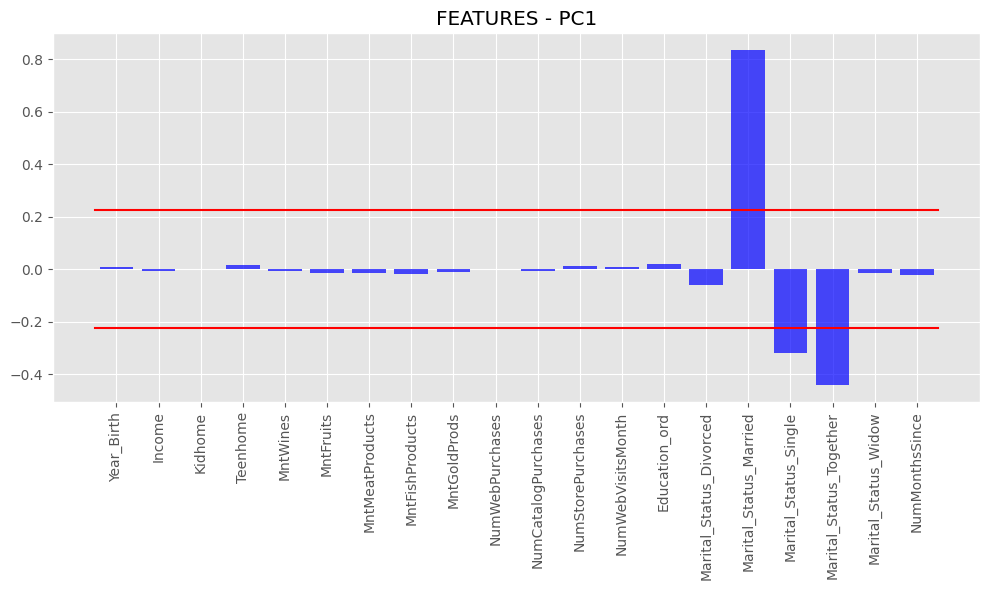


PC2:
	Marital_Status_Single: 0.73
	Marital_Status_Together: -0.67


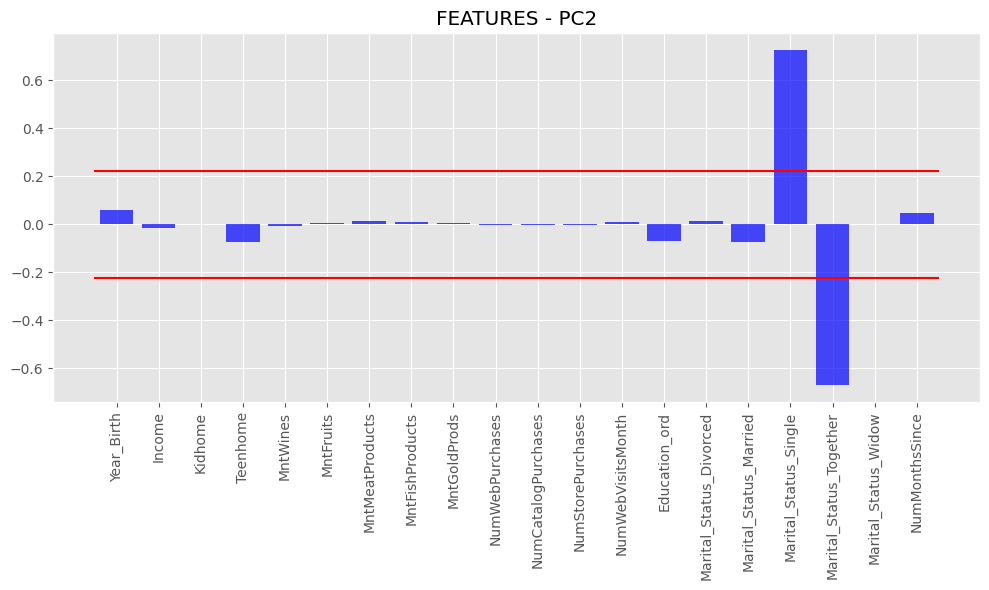

In [45]:
# Get the names of the original features
feature_names = Xworkdf.columns.tolist()
# Get the loadings for each principal component
loadings = pca_mm.components_
# Get the threshold
eps_mm = np.sqrt(1 / pca_mm.n_features_in_)
# Loop through each principal component and print the top 5 features with the highest positive and negative loadings
for i, pc in enumerate(loadings):
    print(f"PC{i+1}:")
    # Top 3 features for each is enough
    top_pos = [j for j in range(len(pc)) if pc[j] > eps_mm][:4]
    top_neg = [j for j in range(len(pc)) if pc[j] < -eps_mm][:4]
    for j in range(len(top_pos)):
        print(f"\t{feature_names[top_pos[j]]}: {pc[top_pos[j]]:.2f}")
    for j in range(len(top_neg)):
        print(f"\t{feature_names[top_neg[j]]}: {pc[top_neg[j]]:.2f}")
        
    plt.bar(Xworkdf.columns, pca_mm.components_[i, :], color='blue', alpha=0.7)
    plt.plot([-0.5, pca_mm.n_features_in_ - 0.5], [eps_mm, eps_mm], 'red')
    plt.plot([-0.5, pca_mm.n_features_in_ - 0.5], [-eps_mm, -eps_mm], 'red')
    
    plt.xticks(ticks=np.arange(pca_mm.n_features_in_), rotation=90)
    plt.title(f'FEATURES - PC{i + 1}')
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    print()

##### Interpretation of PCs - PCA-MM:

**PC1: "Marital Status - Partnership"**: This reflects aspects strongly associated with marital life, particularly being married vs. other forms of partnership.
- This component is heavily dominated by `Marital_Status_Married`, with a very high positive loading. It suggests that this component might capture variance in the data associated with being married.
- `Marital_Status_Single` has negative loadings, indicating an inverse relationship with the married status in this component.

**PC2: "Marital Status - Singleness"**: This captures the contrast between being single and being in a partnership without being married.
- This component has a strong positive loading for `Marital_Status_Single`, indicating that it captures variance associated with being single.
- Conversely, `Marital_Status_Together` has a strong negative loading, which shows an inverse relationship between being single and being in a non-married partnership within this component.

In [46]:
std_names = ['Affluence and Consumption','Youth and Digital Engagement']
mm_names = ['Partnership', 'Singleness']

##### 4.3.a PCA_STD

In [47]:
labels

['NumDealsPurchases',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'Response',
 'Complain',
 'Recency']

For each PCA study, we will visualize some graphs and interpret them.
First, we start with PCA_STD, where we will run a script that prints data points in red and blue representing the customer offer acceptance in one of the campaigns.

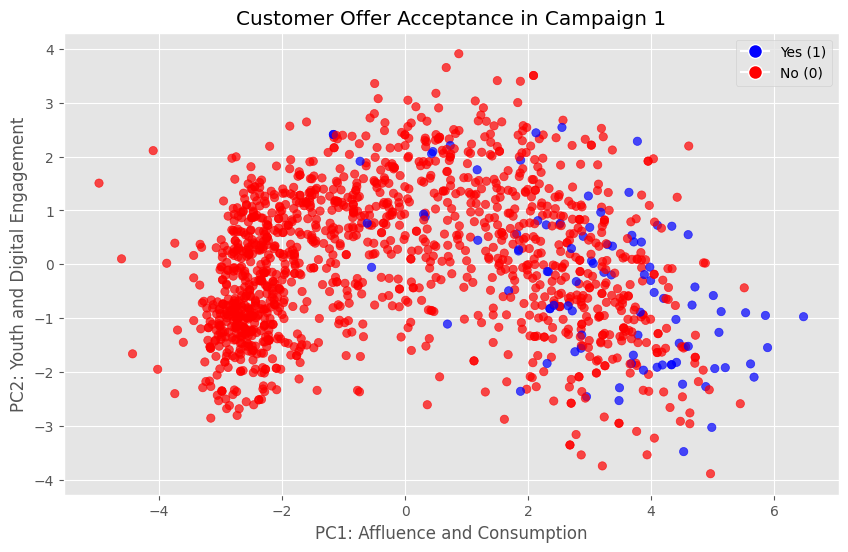

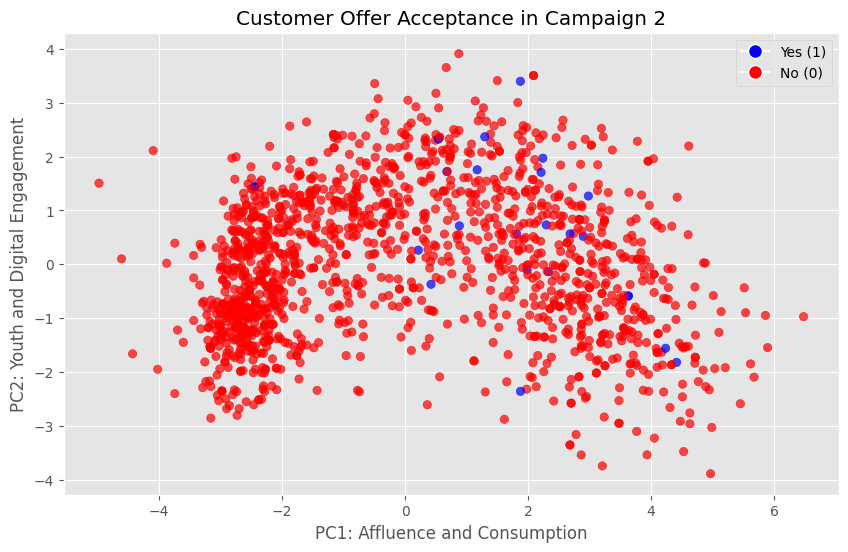

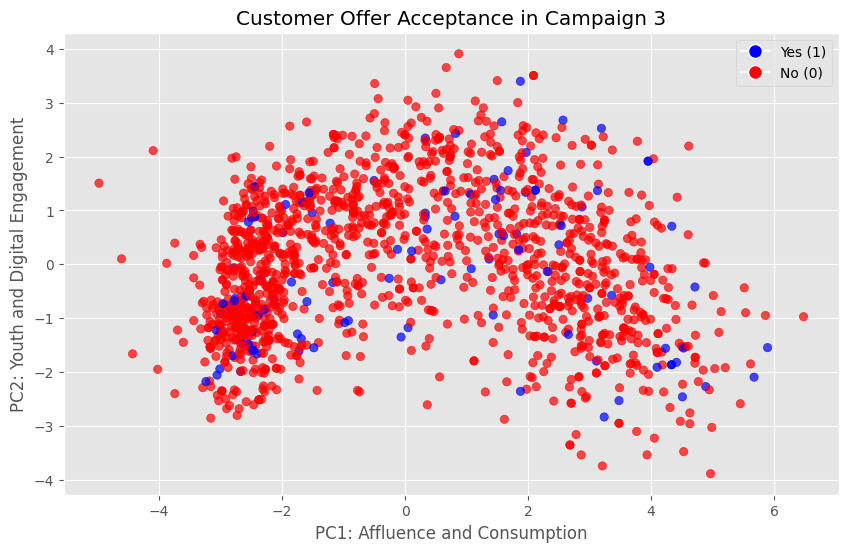

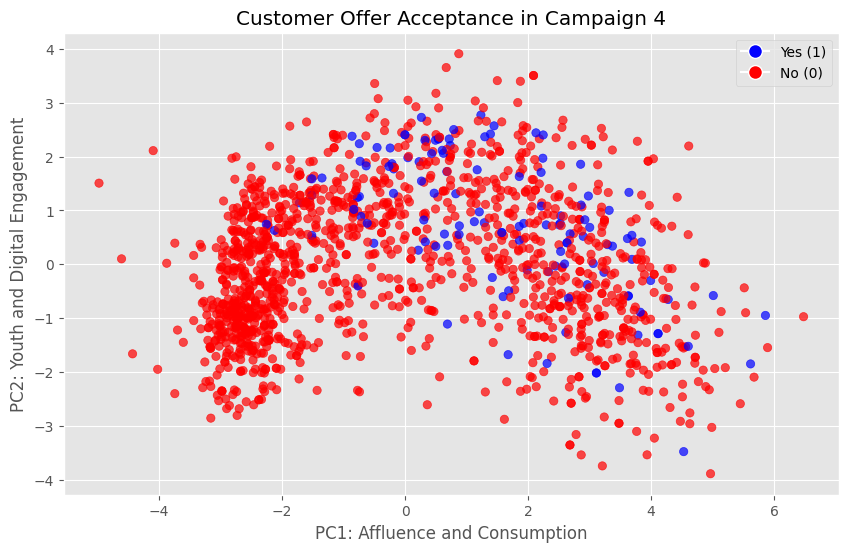

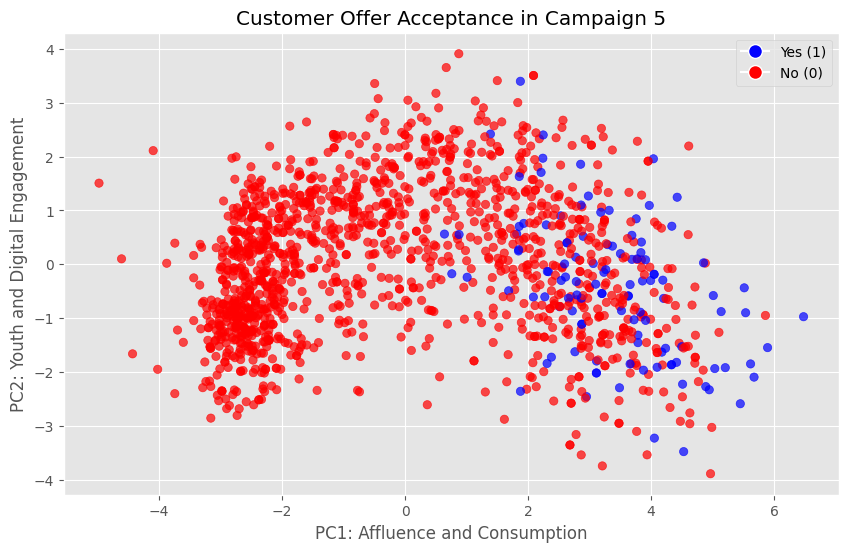

In [48]:
Y_std = pca_std.transform(Xworkdf_std)
for i in range(5):
    plt.scatter(Y_std[:, 0], Y_std[:, 1], c=['blue' if val == 1 else 'red' for val in workdf[f'AcceptedCmp{i+1}']], alpha=0.7)
    plt.xlabel('PC1: Affluence and Consumption')
    plt.ylabel('PC2: Youth and Digital Engagement')

    # Define the labels and their corresponding colors
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Yes (1)',
                            markerfacecolor='blue', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='No (0)',
                            markerfacecolor='red', markersize=10)]

    # Create the legend
    plt.legend(handles=legend_elements, loc='best')
    plt.title(f'Customer Offer Acceptance in Campaign {i+1}')
    plt.grid(True)
    plt.show()

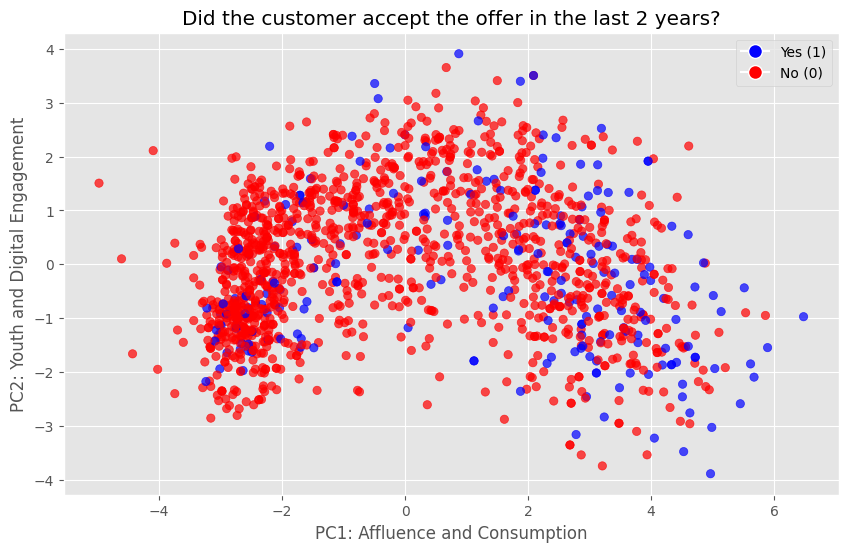

In [49]:
Y_std = pca_std.transform(Xworkdf_std)
plt.scatter(Y_std[:, 0], Y_std[:, 1], c=['blue' if val == 1 else 'red' for val in workdf['Response']], alpha=0.7)
plt.xlabel('PC1: Affluence and Consumption')
plt.ylabel('PC2: Youth and Digital Engagement')

# Define the labels and their corresponding colors
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Yes (1)',
                          markerfacecolor='blue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='No (0)',
                          markerfacecolor='red', markersize=10)]

# Create the legend
plt.legend(handles=legend_elements, loc='best')
plt.title('Did the customer accept the offer in the last 2 years?')
plt.grid(True)
plt.show()

We can clearly see in interesting pattern here that can be summarized into the following points.

1. First, Campaigns are Important! As we can visually notice the increasing number of accepted offers by customers after each campaign. Therefore, one strategy that should the company follows is to do more campaigns, consequently, this will lead to increase profit.
2. We can find the blue points (Accepting an offer) are general on the right side of the graph, PC1 scale is larger, and therefore, we have now an idea about type of customers we have to target within our campaigns.

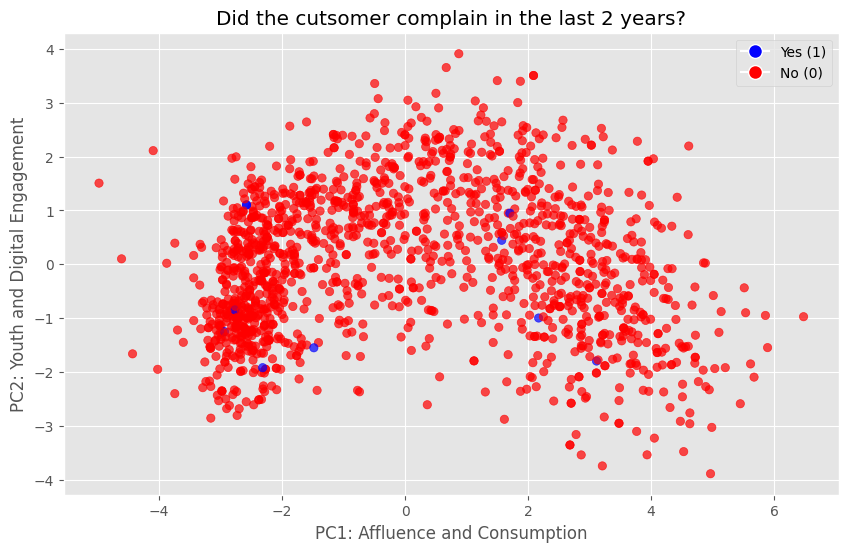

In [50]:
Y_std = pca_std.transform(Xworkdf_std)
plt.scatter(Y_std[:, 0], Y_std[:, 1], c=['blue' if val == 1 else 'red' for val in workdf['Complain']], alpha=0.7)
plt.xlabel('PC1: Affluence and Consumption')
plt.ylabel('PC2: Youth and Digital Engagement')

# Define the labels and their corresponding colors
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Yes (1)',
                          markerfacecolor='blue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='No (0)',
                          markerfacecolor='red', markersize=10)]

# Create the legend
plt.legend(handles=legend_elements, loc='best')
plt.title('Did the cutsomer complain in the last 2 years?')
plt.grid(True)
plt.show()

This graph reflects to the *high satisfaction* of customers (No. of complaints very low). The complaints received are spread within the space and it is hard to categorize people who did complain.

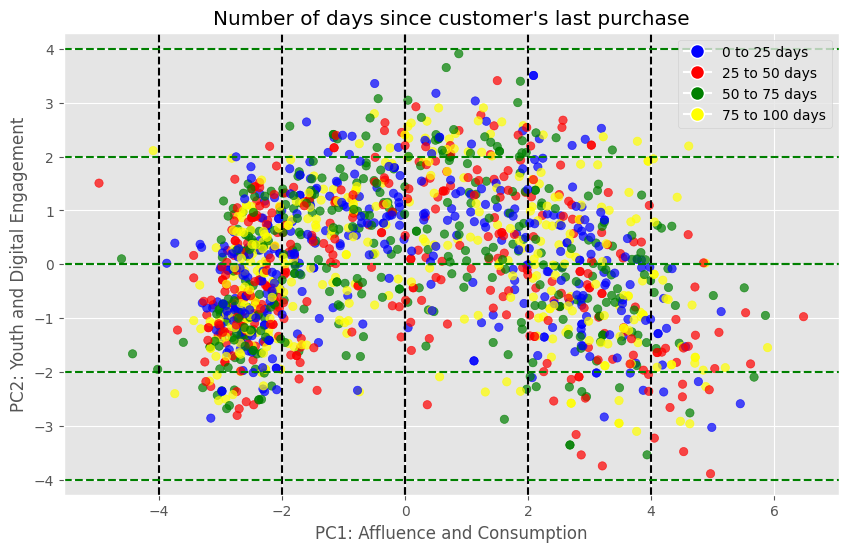

In [51]:
color_names = ['blue', 'red', 'green', 'yellow']
plt.scatter(Y_std[:, 0], Y_std[:, 1], c=[color_names[val//25] for val in workdf['Recency']], alpha=0.7)
plt.xlabel('PC1: Affluence and Consumption')
plt.ylabel('PC2: Youth and Digital Engagement')

# Define the labels and their corresponding colors
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"{val} to {val+25} days",
                          markerfacecolor=color_names[val//25], markersize=10) for val in range(0, 100, 25)]

for i in range(3):
    plt.axvline(x=2*i, color='black', linestyle='--')
    plt.axvline(x=-2*i, color='black', linestyle='--')
    plt.axhline(y=2*i, color='green', linestyle='--')
    plt.axhline(y=-2*i, color='green', linestyle='--')

# Create the legend
plt.legend(handles=legend_elements, loc='best')
plt.title('Number of days since customer\'s last purchase')
plt.grid(True)
plt.show()

I divided this graph into small boxes to make the data distribution more readable, we can see that customers last purchase is distributed within all boxes and this makes the interpretation difficult. While we can observe a dominance of blue points (0 to 25 days) which means that our customers are  confident to buy from our company, indeed, we have to keep this relation with them.

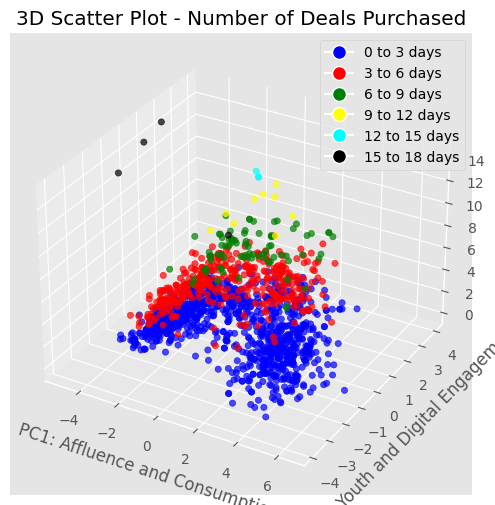

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
color_names = ['blue', 'red', 'green', 'yellow', 'cyan', 'black']
ax.scatter(Y_std[:, 0], Y_std[:, 1], workdf['NumDealsPurchases'], c=[color_names[int(val//3)] for val in workdf['NumDealsPurchases']], alpha=0.7)

ax.set_xlabel('PC1: Affluence and Consumption')
ax.set_ylabel('PC2: Youth and Digital Engagement')
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"{val} to {val+3} days",
                          markerfacecolor=color_names[int(val//3)], markersize=10) for val in range(0, 16, 3)]
plt.legend(handles=legend_elements, loc='best')
plt.title('3D Scatter Plot - Number of Deals Purchased')
plt.show()

Finally, this 3D plot is the same the previous 2D plot, while in 3D we can have a better visualization of the data.

##### 4.3.b PCA_MM

Now, we do the same work with PCA_MM.

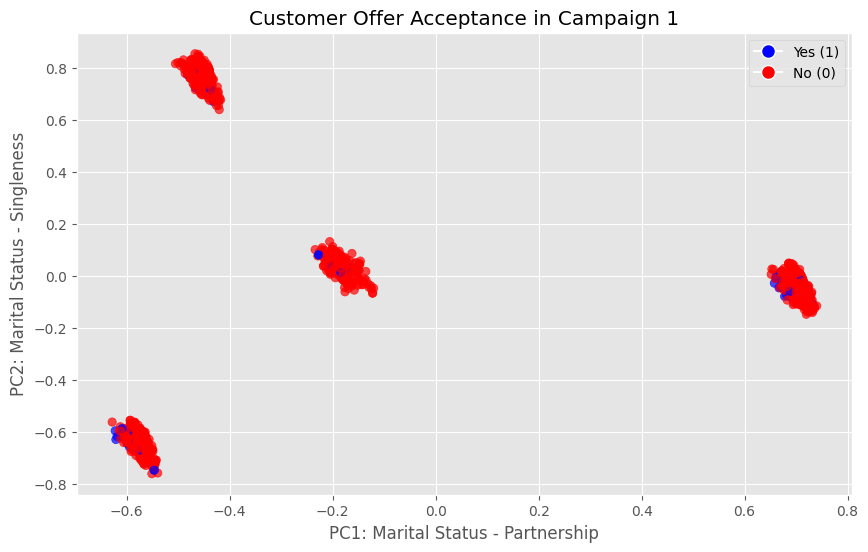

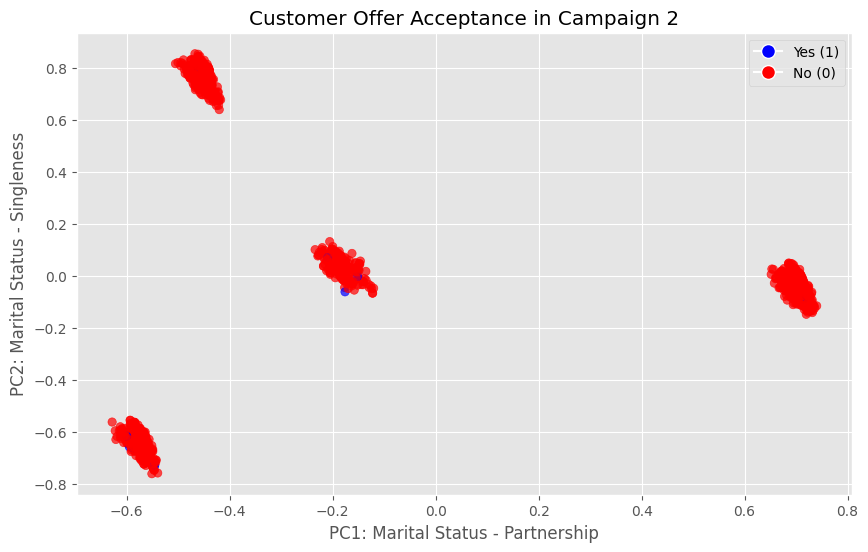

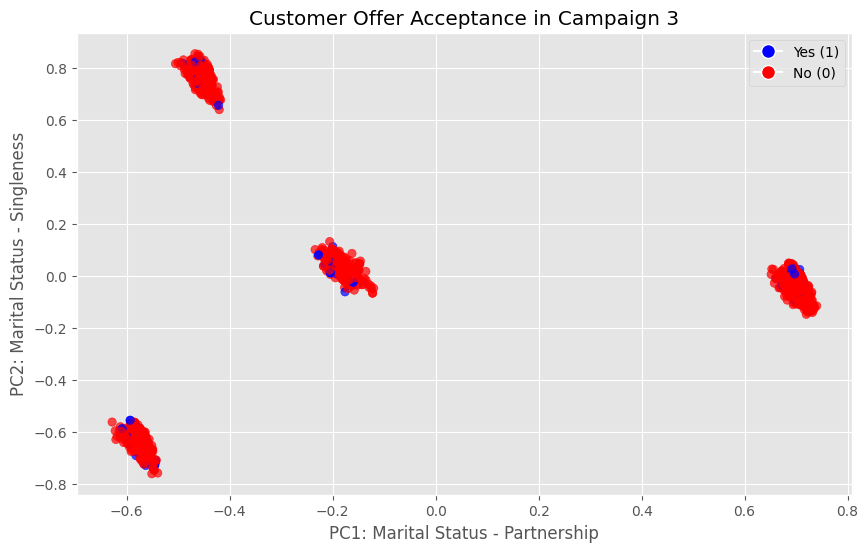

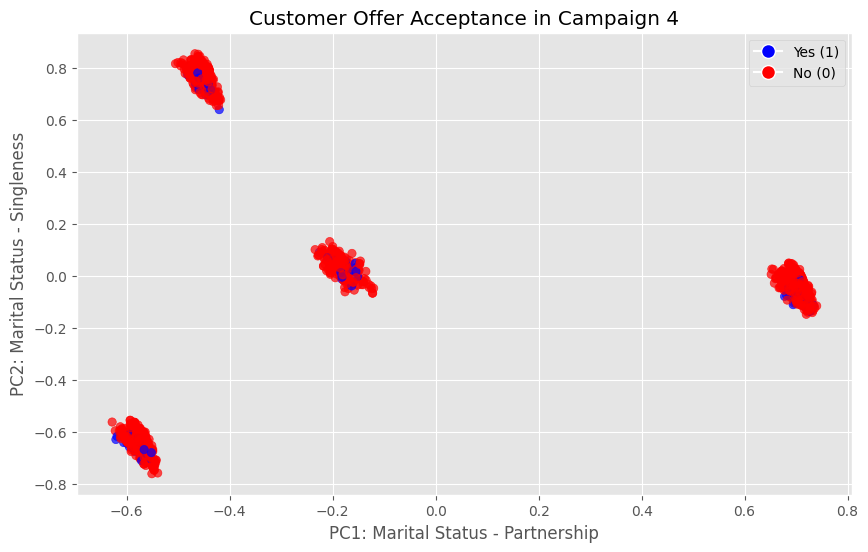

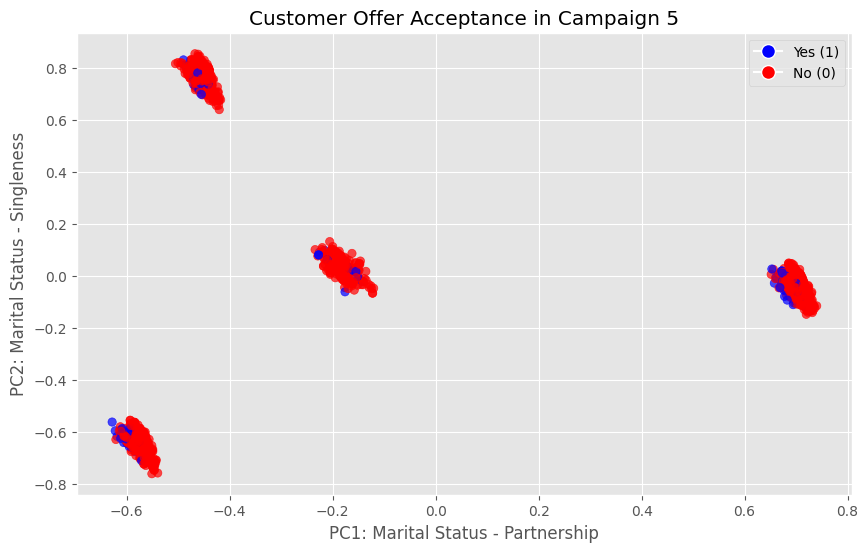

In [53]:
Y_mm = pca_mm.transform(Xworkdf_mm)
for i in range(5):
    plt.scatter(Y_mm[:, 0], Y_mm[:, 1], c=['blue' if val == 1 else 'red' for val in workdf[f'AcceptedCmp{i+1}']], alpha=0.7)
    plt.xlabel('PC1: Marital Status - Partnership')
    plt.ylabel('PC2: Marital Status - Singleness')

    # Define the labels and their corresponding colors
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Yes (1)',
                            markerfacecolor='blue', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='No (0)',
                            markerfacecolor='red', markersize=10)]

    # Create the legend
    plt.legend(handles=legend_elements, loc='best')
    plt.title(f'Customer Offer Acceptance in Campaign {i+1}')
    plt.grid(True)
    plt.show()

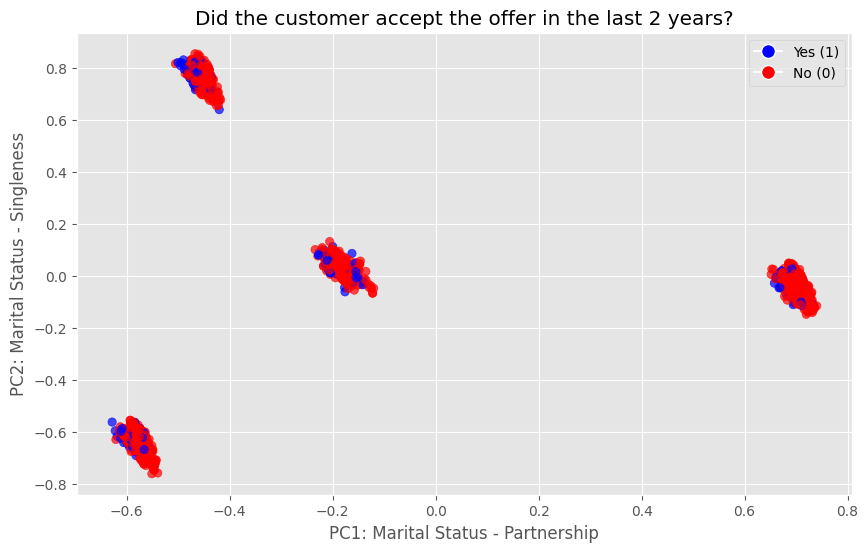

In [54]:
Y_mm = pca_mm.transform(Xworkdf_mm)
plt.scatter(Y_mm[:, 0], Y_mm[:, 1], c=['blue' if val == 1 else 'red' for val in workdf['Response']], alpha=0.7)
plt.xlabel('PC1: Marital Status - Partnership')
plt.ylabel('PC2: Marital Status - Singleness')

# Define the labels and their corresponding colors
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Yes (1)',
                          markerfacecolor='blue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='No (0)',
                          markerfacecolor='red', markersize=10)]

# Create the legend
plt.legend(handles=legend_elements, loc='best')
plt.title('Did the customer accept the offer in the last 2 years?')
plt.grid(True)
plt.show()

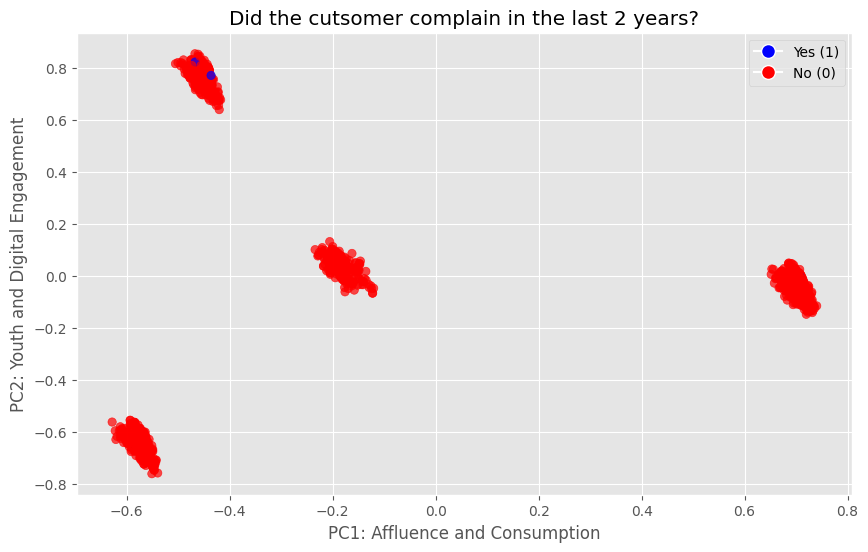

In [55]:
plt.scatter(Y_mm[:, 0], Y_mm[:, 1], c=['blue' if val == 1 else 'red' for val in workdf['Complain']], alpha=0.7)
plt.xlabel('PC1: Affluence and Consumption')
plt.ylabel('PC2: Youth and Digital Engagement')

# Define the labels and their corresponding colors
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Yes (1)',
                          markerfacecolor='blue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='No (0)',
                          markerfacecolor='red', markersize=10)]

# Create the legend
plt.legend(handles=legend_elements, loc='best')
plt.title('Did the cutsomer complain in the last 2 years?')
plt.grid(True)
plt.show()

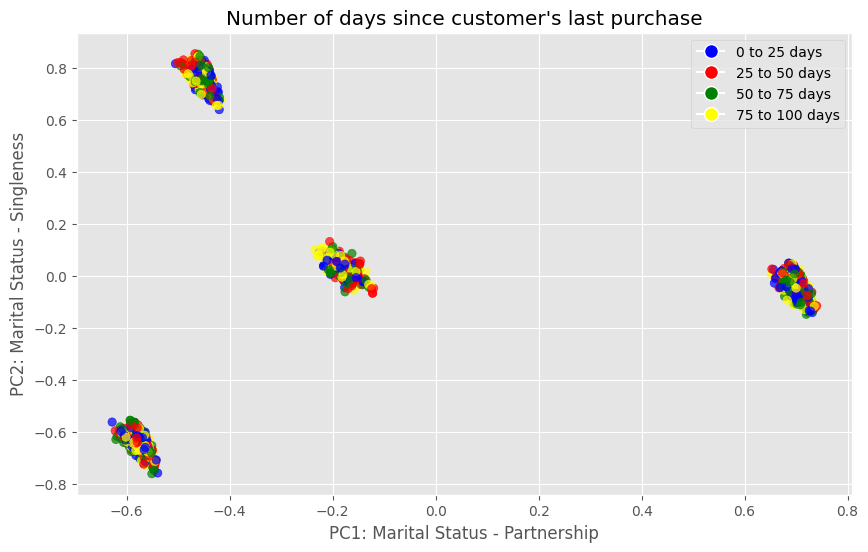

In [56]:
color_names = ['blue', 'red', 'green', 'yellow']
plt.scatter(Y_mm[:, 0], Y_mm[:, 1], c=[color_names[val//25] for val in workdf['Recency']], alpha=0.7)
plt.xlabel('PC1: Marital Status - Partnership')
plt.ylabel('PC2: Marital Status - Singleness')

# Define the labels and their corresponding colors
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"{val} to {val+25} days",
                          markerfacecolor=color_names[val//25], markersize=10) for val in range(0, 100, 25)]

# Create the legend
plt.legend(handles=legend_elements, loc='best')
plt.title('Number of days since customer\'s last purchase')
plt.grid(True)
plt.show()

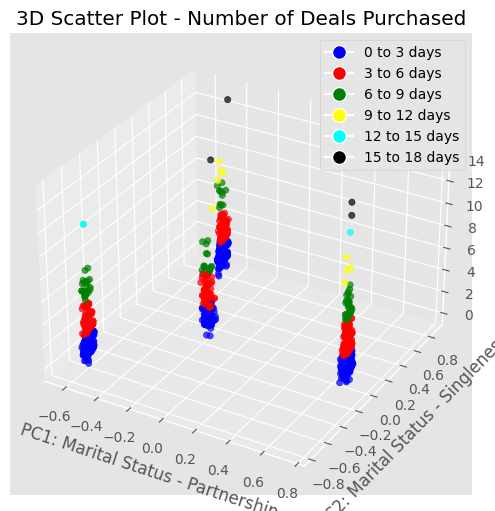

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
color_names = ['blue', 'red', 'green', 'yellow','cyan', 'black']
ax.scatter(Y_mm[:, 0], Y_mm[:, 1], workdf['NumDealsPurchases'], c=[color_names[int(val//3)] for val in workdf['NumDealsPurchases']], alpha=0.7)

ax.set_xlabel('PC1: Marital Status - Partnership')
ax.set_ylabel('PC2: Marital Status - Singleness')
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"{val} to {val+3} days",
                          markerfacecolor=color_names[int(val//3)], markersize=10) for val in range(0, 16, 3)]
plt.legend(handles=legend_elements, loc='best')
plt.title('3D Scatter Plot - Number of Deals Purchased')
plt.show()

#### Exercise 5 (k-Means)

In [58]:
Y_std.shape , Y_mm.shape

((1458, 2), (1458, 2))

In [59]:
km_list = []
silcoeff_list = []
k_list = range(3, 10+1)

methods = ['Standardized Scalar', 'MinMax Scalar']
# Iterate over each dataframe
for i, y in enumerate([Y_std, Y_mm]):
    print(f"Results obtained using {methods[i]}:\n")
    best_score = -1
    best_k = None
    for k in k_list:
        # Fit the k-means model
        model = KMeans(n_clusters=k, random_state=rs , n_init=5, init='k-means++', tol=0.0001).fit(y)
        # Calculate the silhouette score
        score = silhouette_score(y, model.labels_)
        print(f"k = {k}, silhouette score = {score:.4f}")
        # Update the best score and k value if necessary
        if score > best_score:
            best_score = score
            best_k = k
            if i == 0:
                kmeans_std = model
            else:
                kmeans_mm = model
            
    print(f"Best value of k= {best_k}, silhouette score = {best_score:.4f} \n")

Results obtained using Standardized Scalar:

k = 3, silhouette score = 0.4688
k = 4, silhouette score = 0.4102
k = 5, silhouette score = 0.3813
k = 6, silhouette score = 0.3989
k = 7, silhouette score = 0.3813
k = 8, silhouette score = 0.3735
k = 9, silhouette score = 0.3752
k = 10, silhouette score = 0.3305
Best value of k= 3, silhouette score = 0.4688 

Results obtained using MinMax Scalar:

k = 3, silhouette score = 0.8315
k = 4, silhouette score = 0.9355
k = 5, silhouette score = 0.7682
k = 6, silhouette score = 0.6582
k = 7, silhouette score = 0.5603
k = 8, silhouette score = 0.5290
k = 9, silhouette score = 0.4664
k = 10, silhouette score = 0.4589
Best value of k= 4, silhouette score = 0.9355 



Now, we've got our best value of K for both methods. We have to mention that the silhouette score for k=4 for MinMax Scaled Data in around 0.93 which is a really good score and we can get good clusters using this model.

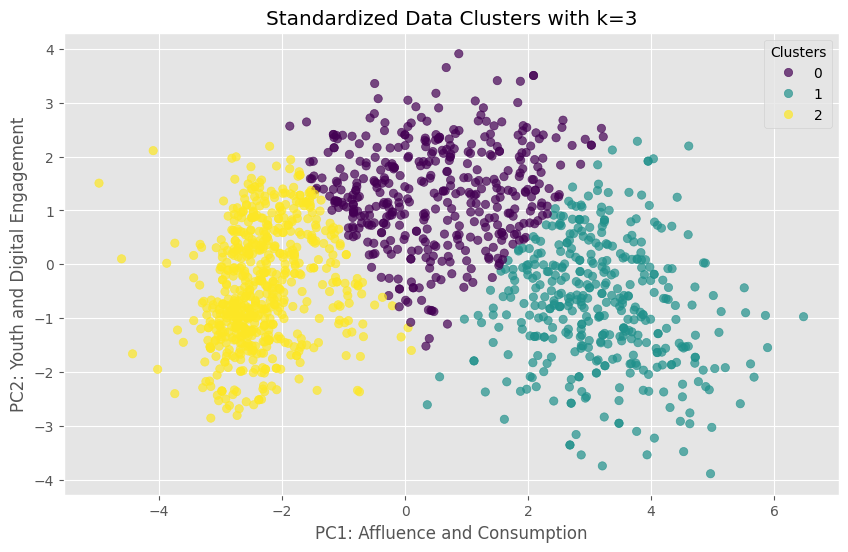

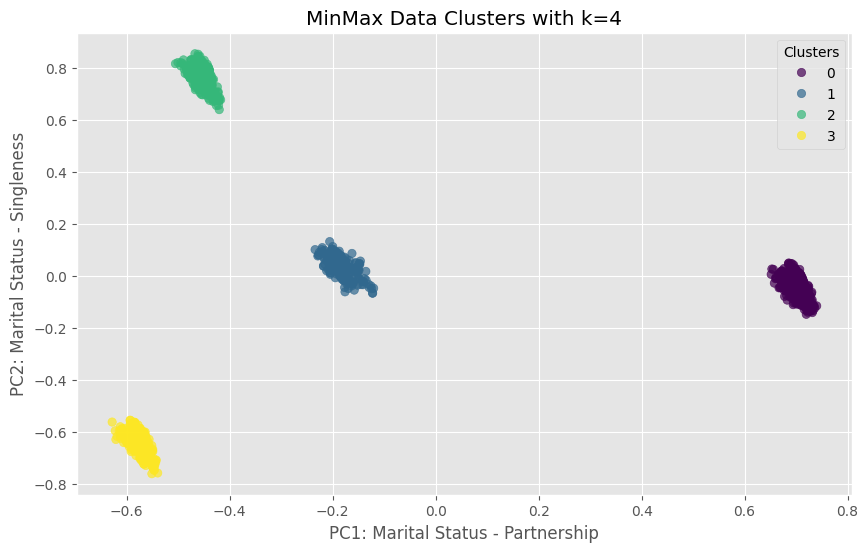

In [60]:
# Visualize the clusters for Standardized Data
best_k_std= 3
scatter = plt.scatter(Y_std[:, 0], Y_std[:, 1], c=kmeans_std.labels_, cmap='viridis', alpha=0.7)
plt.title(f'Standardized Data Clusters with k={best_k_std}')
plt.xlabel('PC1: Affluence and Consumption')
plt.ylabel('PC2: Youth and Digital Engagement')
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

# Visualize the clusters for MinMax Data
best_k_mm = 4
scatter2 = plt.scatter(Y_mm[:, 0], Y_mm[:, 1], c=kmeans_mm.labels_, cmap='viridis', alpha=0.7)
plt.title(f'MinMax Data Clusters with k={best_k_mm}')
plt.xlabel('PC1: Marital Status - Partnership')
plt.ylabel('PC2: Marital Status - Singleness')
legend2 = plt.legend(*scatter2.legend_elements(), title="Clusters")
plt.show()


Here we can visualized the clusters for each method, we have well-separated Clusters for MinMax

#### Exercise 6 (Clusters and Centroid Interpretation)

**Naming Clusters**

1. For Standard Scaled Data (PCA-STD):
- Cluster 1: "Digital Family" (Cyan)\
    This cluster seems to be characterized by a higher presence of teenagers and a stronger engagement in online activities, reflected in the higher values of PC2 ("Youth and Digital Engagement").
    The customers in this cluster might be middle-aged parents with teenage children who are comfortable with online purchases and digital interaction.

- Cluster 2: "Traditional Spenders" (Purple)\
    This cluster may include customers who are traditional in their spending habits, perhaps older, with fewer teenagers at home, and less inclined to engage in digital activities or spend on luxury items.
    
- Cluster 3: "Affluent Connoisseurs" (Yellow)\
    With high values on PC1 ("Affluence and Consumption") and lower values on PC2, this cluster likely represents wealthy individuals who spend significantly on luxury items such as wines, meats, and fruits. They may have fewer children at home and prefer in-store shopping experiences over online activities.
    
2. For MinMax Scaled Data (PCA-MM):
- Cluster 1: "Committed Partners" (Green)\
    Dominated by a high positive loading on PC1 ("Marital Status - Partnership"), this cluster might consist of married customers, possibly with a more traditional household setup and spending patterns.
    
- Cluster 2: "Independent Singles" (Blue)\
    This cluster, showing high values on PC2 ("Marital Status - Singleness"), is likely to represent single individuals who are not in a partnership. They might have different consumption habits, possibly more individualistic and independent.
    
- Cluster 3: "Balanced Singles" (Purple)\
    With moderate values on both PCs, this cluster could represent single individuals who balance between being single and being in a non-married partnership, showing a mix of traits from the other clusters.

- Cluster 4: "Young Partners" (Yellow)\
    Exhibiting negative loadings on both PCs, this cluster might include younger individuals in non-married partnerships, potentially with distinctive spending and engagement habits compared to the married or single clusters.

In both datasets, these clusters reflect distinct demographic and behavioral segments, with the Standard Scaled data focusing more on consumption and digital engagement patterns, while the MinMax Scaled data highlights marital status and related lifestyle choices. The names and descriptions are based on the loadings of the principal components and the average position of the centroids within each cluster.

In [61]:
# Get the cluster labels and centroids
labels_std = kmeans_std.labels_
centroids_std = kmeans_std.cluster_centers_
# Define a list of feature names
feature_names = std_names
# Convert array to dataframe with column names
Yworkdf_std_df = pd.DataFrame(Y_std, columns=[f"{feature_names[i]}" for i in range(len(feature_names))])
# Iterate over each cluster to interpret the centroids and assign names
for i in range(centroids_std.shape[0]):
    # Get the indices of the data points in the cluster
    cluster_indices = np.where(labels_std == i)[0]
    # Get the mean values of the principal components for the cluster
    mean_pc_values = np.mean(Yworkdf_std_df.iloc[cluster_indices], axis=0)
    # Find the index of the principal component with the highest absolute value
    dominant_pc_index = np.argmax(np.abs(mean_pc_values))
    # Get the sign of the dominant principal component
    dominant_pc_sign = np.sign(mean_pc_values[dominant_pc_index])
    # Get the name of the feature that corresponds to the dominant principal component
    dominant_feature = feature_names[dominant_pc_index]
    # Assign a name to the cluster based on the dominant feature and sign
    
    cluster_name = ''
    if dominant_pc_sign > 0:
        cluster_name += 'High '
    else:
        cluster_name += 'Low '
    cluster_name += dominant_feature
    # Print the name and mean principal component values for the cluster
    print(f'Cluster {i+1}: Customers with {cluster_name}')
    print(f'Mean PC values: {mean_pc_values}\n')

Cluster 1: Customers with High Youth and Digital Engagement
Mean PC values: Affluence and Consumption       0.505286
Youth and Digital Engagement    1.304145
dtype: float64

Cluster 2: Customers with High Affluence and Consumption
Mean PC values: Affluence and Consumption       3.165415
Youth and Digital Engagement   -0.738074
dtype: float64

Cluster 3: Customers with Low Affluence and Consumption
Mean PC values: Affluence and Consumption      -2.313050
Youth and Digital Engagement   -0.398987
dtype: float64



C:\Users\a_h9\AppData\Local\Temp\ipykernel_4336\188488865.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dominant_pc_sign = np.sign(mean_pc_values[dominant_pc_index])


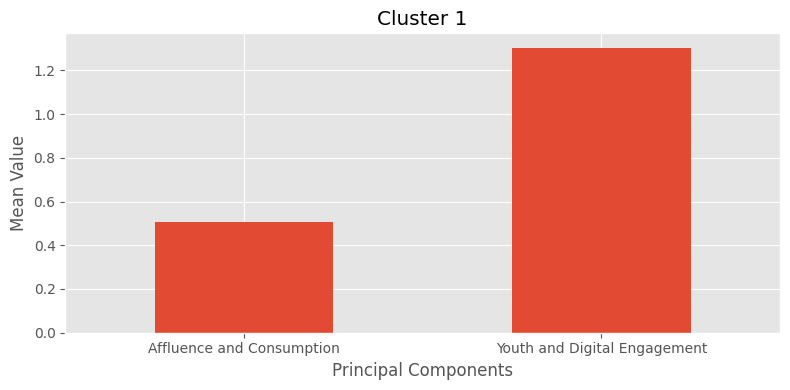

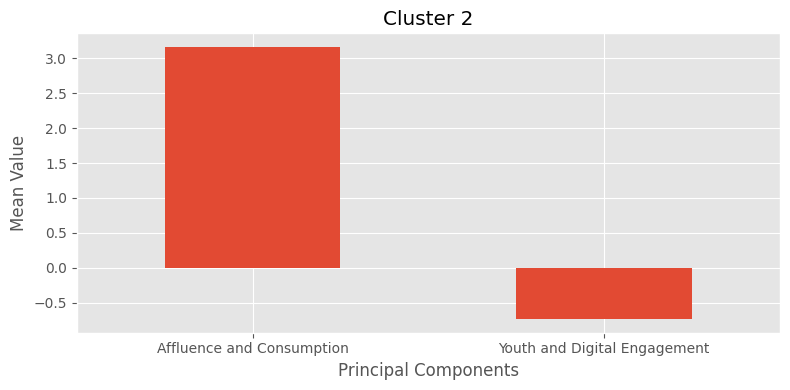

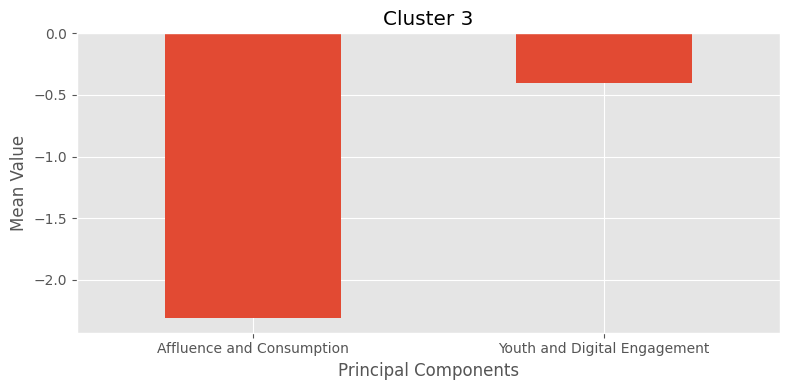

In [62]:
# Create bar plots for each cluster
for i in range(centroids_std.shape[0]):
    cluster_indices = np.where(labels_std == i)[0]
    mean_pc_values = np.mean(Yworkdf_std_df.iloc[cluster_indices], axis=0)
    
    plt.figure(figsize=(8, 4))
    mean_pc_values.plot(kind='bar')
    plt.title(f'Cluster {i+1}')
    plt.xticks(rotation=0)
    plt.ylabel('Mean Value')
    plt.xlabel('Principal Components')
    plt.tight_layout()
    plt.show()


In [63]:
# Get the cluster labels and centroids
labels_mm = kmeans_mm.labels_
centroids_mm = kmeans_mm.cluster_centers_
# Define a list of feature names
feature_names = mm_names
# Convert array to dataframe with column names
Yworkdf_mm_df = pd.DataFrame(Y_mm, columns=[f"{feature_names[i]}" for i in range(len(feature_names))])
# Iterate over each cluster to interpret the centroids and assign names
for i in range(centroids_mm.shape[0]):
    # Get the indices of the data points in the cluster
    cluster_indices = np.where(labels_mm == i)[0]
    # Get the mean values of the principal components for the cluster
    mean_pc_values = np.mean(Yworkdf_mm_df.iloc[cluster_indices], axis=0)
    # Find the index of the principal component with the highest absolute value
    dominant_pc_index = np.argmax(np.abs(mean_pc_values))
    # Get the sign of the dominant principal component
    dominant_pc_sign = np.sign(mean_pc_values[dominant_pc_index])
    # Get the name of the feature that corresponds to the dominant principal component
    dominant_feature = feature_names[dominant_pc_index]
    # Assign a name to the cluster based on the dominant feature and sign
    
    cluster_name = ''
    if dominant_pc_sign > 0:
        cluster_name += 'High '
    else:
        cluster_name += 'Low '
    cluster_name += dominant_feature
    # Print the name and mean principal component values for the cluster
    print(f'Cluster {i+1}: Customers with {cluster_name}')
    print(f'Mean PC values: {mean_pc_values}\n')

Cluster 1: Customers with High Partnership
Mean PC values: Partnership    0.702975
Singleness    -0.045642
dtype: float64

Cluster 2: Customers with Low Partnership
Mean PC values: Partnership   -0.181078
Singleness     0.031105
dtype: float64

Cluster 3: Customers with High Singleness
Mean PC values: Partnership   -0.453381
Singleness     0.765900
dtype: float64

Cluster 4: Customers with Low Singleness
Mean PC values: Partnership   -0.575372
Singleness    -0.644928
dtype: float64



C:\Users\a_h9\AppData\Local\Temp\ipykernel_4336\1997588470.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dominant_pc_sign = np.sign(mean_pc_values[dominant_pc_index])


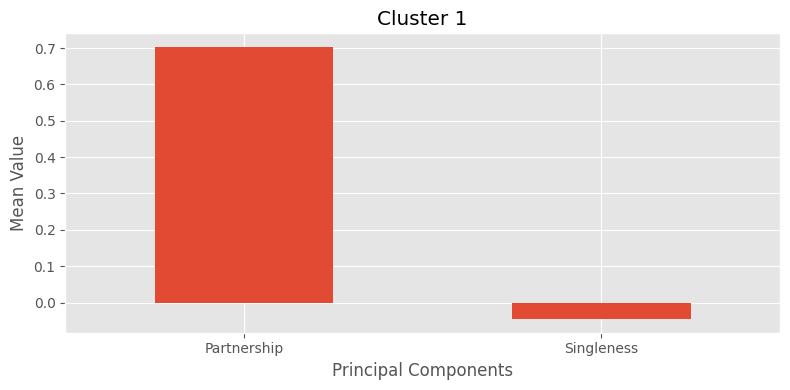

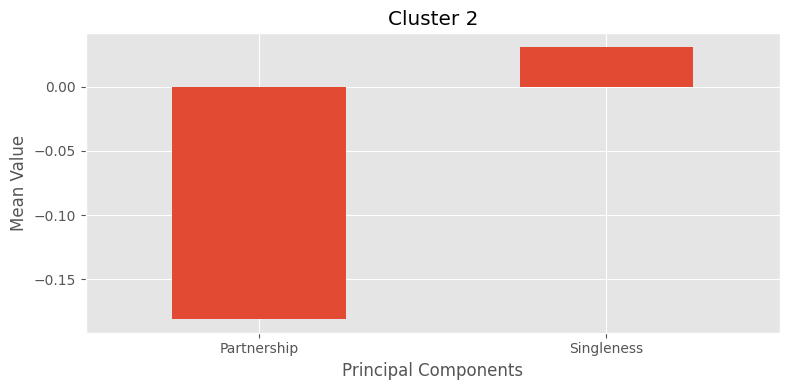

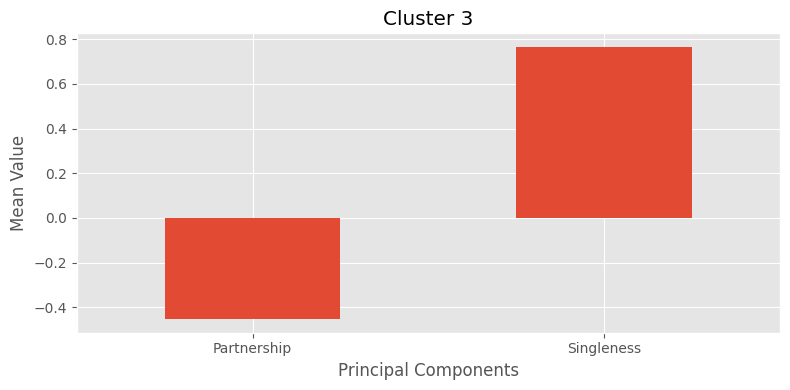

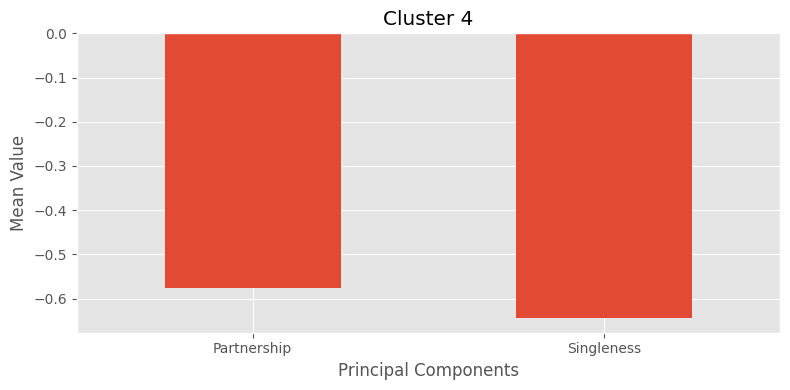

In [64]:
# Create bar plots for each cluster
for i in range(centroids_mm.shape[0]):
    cluster_indices = np.where(labels_mm == i)[0]
    mean_pc_values = np.mean(Yworkdf_mm_df.iloc[cluster_indices], axis=0)
    
    plt.figure(figsize=(8, 4))
    mean_pc_values.plot(kind='bar')
    plt.title(f'Cluster {i+1}')
    plt.xticks(rotation=0)
    plt.ylabel('Mean Value')
    plt.xlabel('Principal Components')
    plt.tight_layout()
    plt.show()


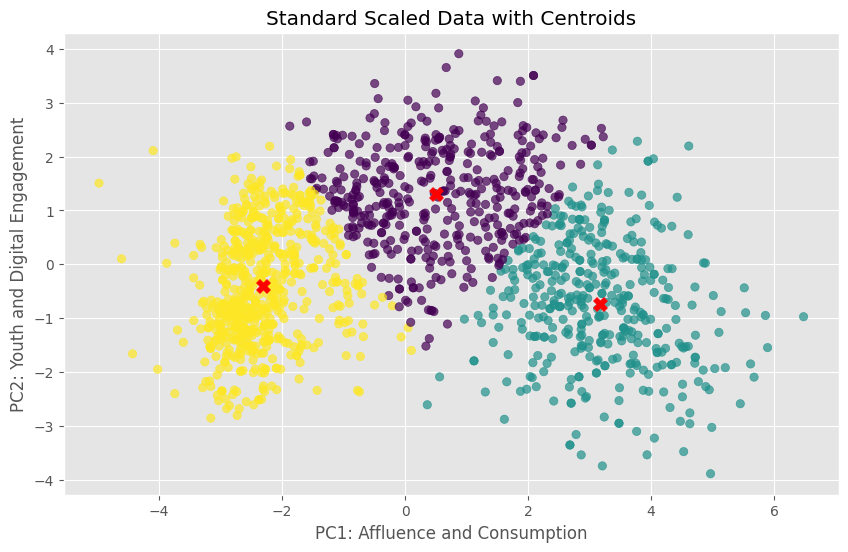

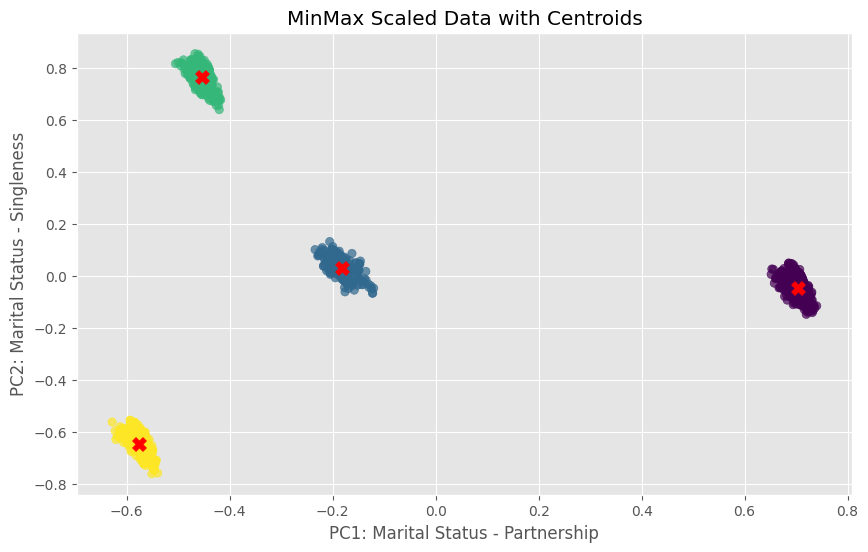

In [65]:
# Plot score graph for standardized data with centroids
plt.scatter(Y_std[:, 0], Y_std[:, 1], c=kmeans_std.labels_, cmap='viridis', alpha=0.7)
plt.scatter(kmeans_std.cluster_centers_[:, 0], kmeans_std.cluster_centers_[:, 1], c='red', s=100, marker='X')  # Centroids in red
plt.xlabel('PC1: Affluence and Consumption')
plt.ylabel('PC2: Youth and Digital Engagement')
plt.title('Standard Scaled Data with Centroids')
plt.grid(True)
plt.show()

# Plot score graph for MinMax scaled data with centroids
plt.scatter(Y_mm[:, 0], Y_mm[:, 1], c=kmeans_mm.labels_, cmap='viridis', alpha=0.7)
plt.scatter(kmeans_mm.cluster_centers_[:, 0], kmeans_mm.cluster_centers_[:, 1], c='red', s=100, marker='X')  # Centroids in red
plt.xlabel('PC1: Marital Status - Partnership')
plt.ylabel('PC2: Marital Status - Singleness')
plt.title('MinMax Scaled Data with Centroids')
plt.grid(True)
plt.show()


#### Exercise 7

In [66]:
# Calculate the silhouette score for the Standard Scaled Data clusters
silhouette_std = silhouette_score(Y_std, kmeans_std.labels_)
print(f"Silhouette score for Standard Scaled Data clusters: {silhouette_std:.4f}")

# Calculate the silhouette score for the MinMax Scaled Data clusters
silhouette_mm = silhouette_score(Y_mm, kmeans_mm.labels_)
print(f"Silhouette score for MinMax Scaled Data clusters: {silhouette_mm:.4f}")

Silhouette score for Standard Scaled Data clusters: 0.4688
Silhouette score for MinMax Scaled Data clusters: 0.9355


In [67]:
labels

['NumDealsPurchases',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'Response',
 'Complain',
 'Recency']

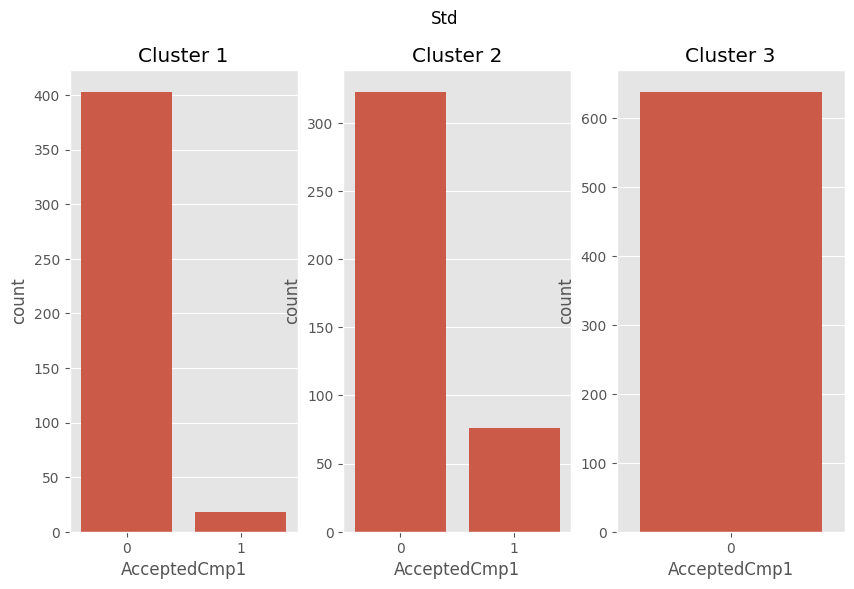

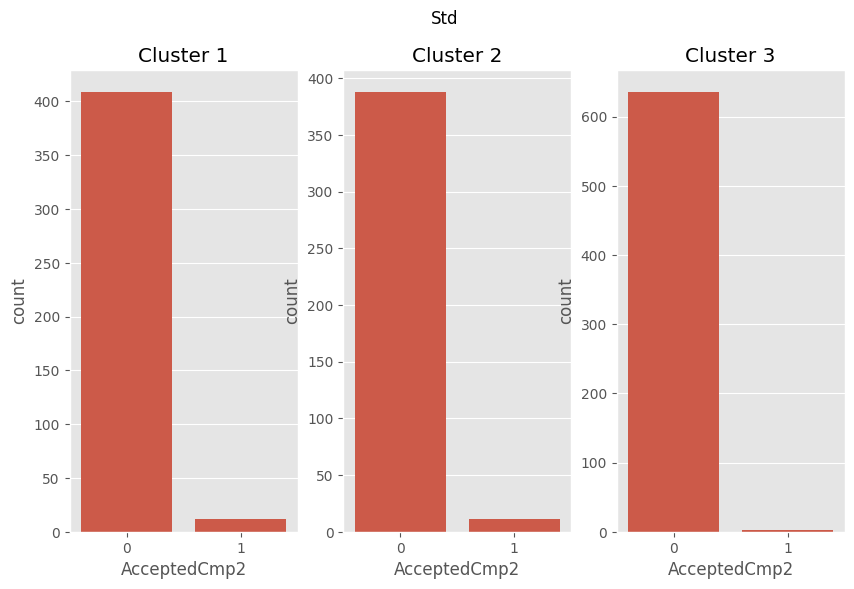

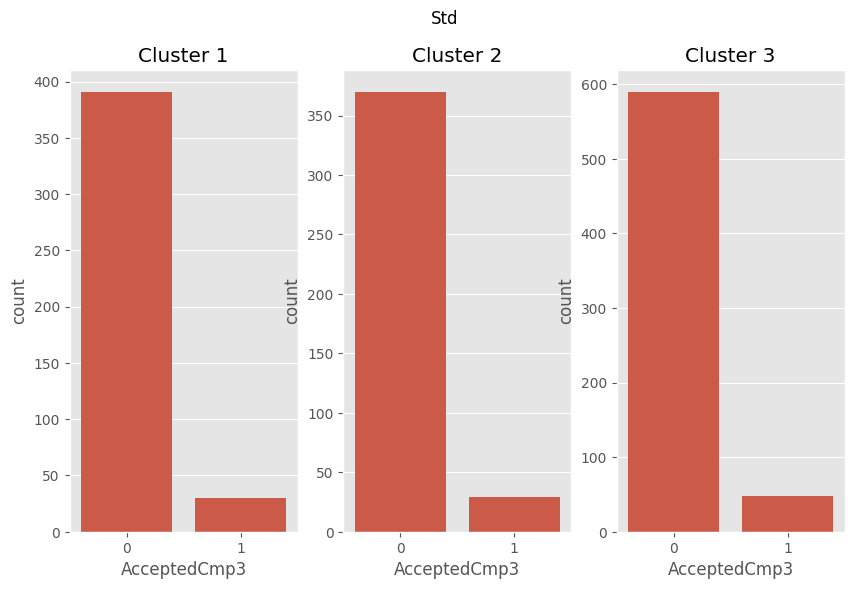

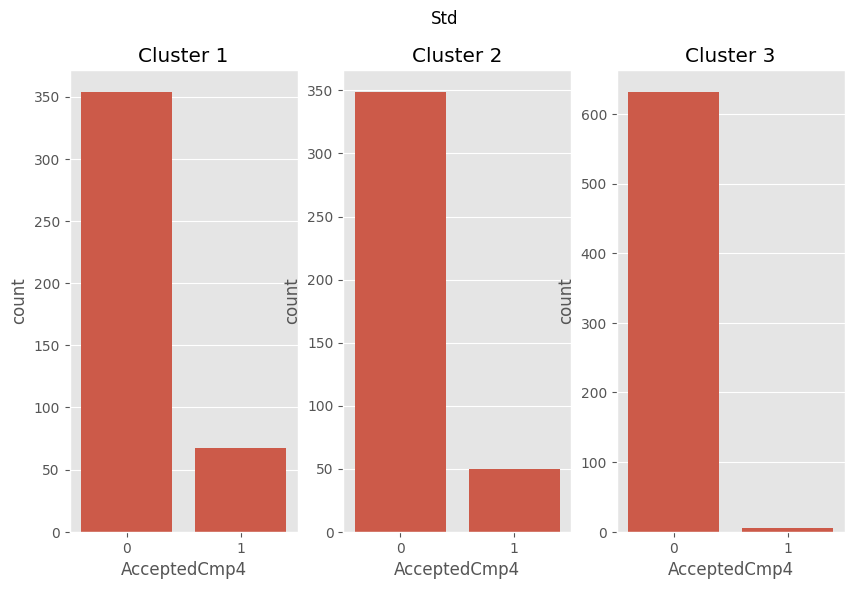

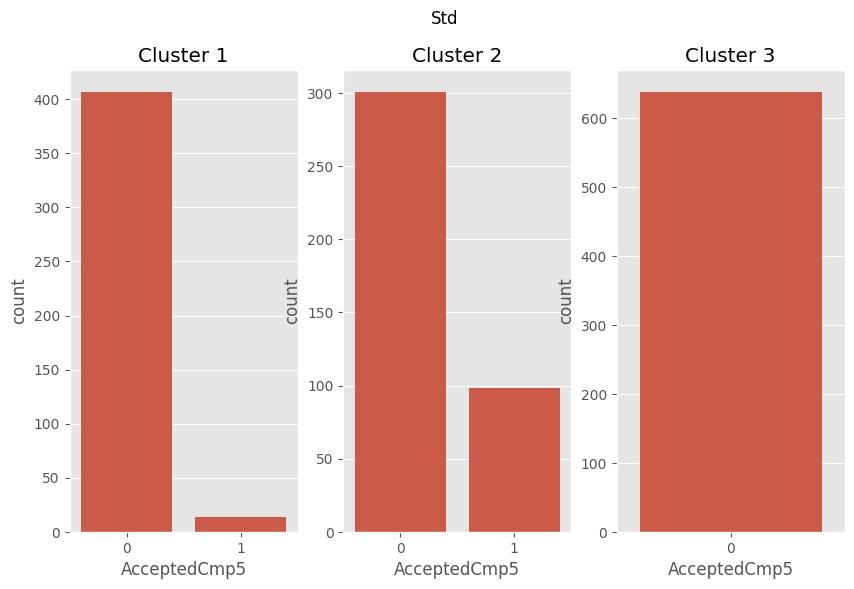

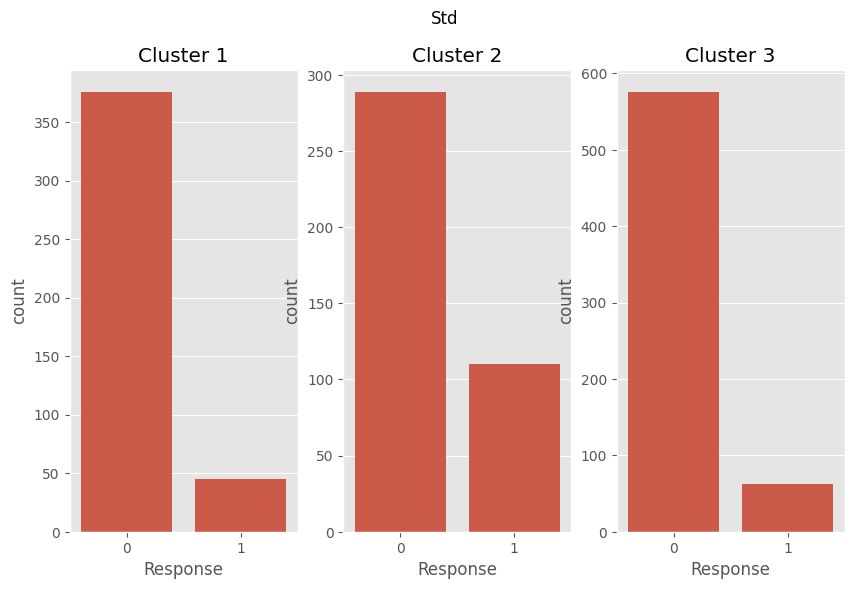

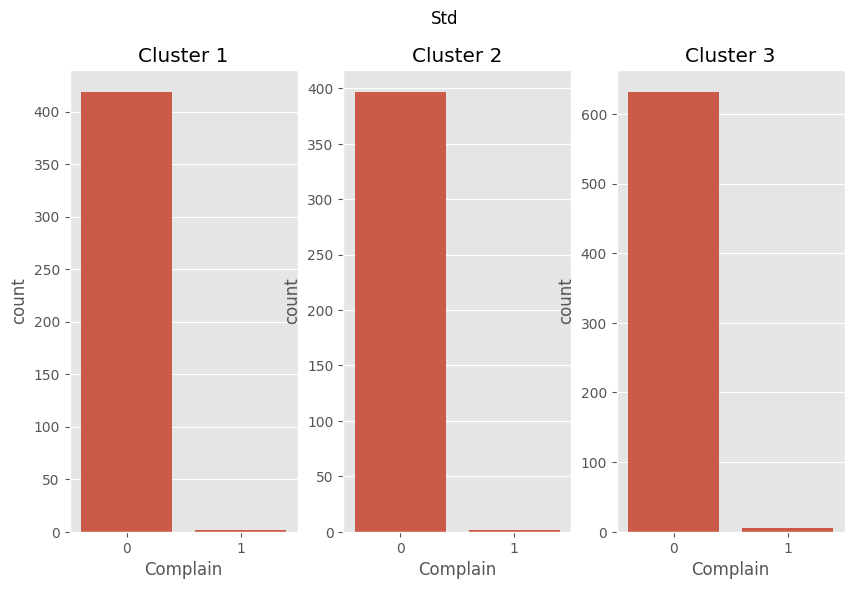

In [68]:
import seaborn as sns
labels_categorical = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']
for label in labels_categorical:
    for i in range(3): # k=3
        cluster_labels = workdf[kmeans_std.labels_ == i][label]
        plt.subplot(1, best_k_std, i+1)
        sns.countplot(x=cluster_labels)
        plt.suptitle(f'Std')
        plt.title(f'Cluster {i+1}')
    plt.show()  

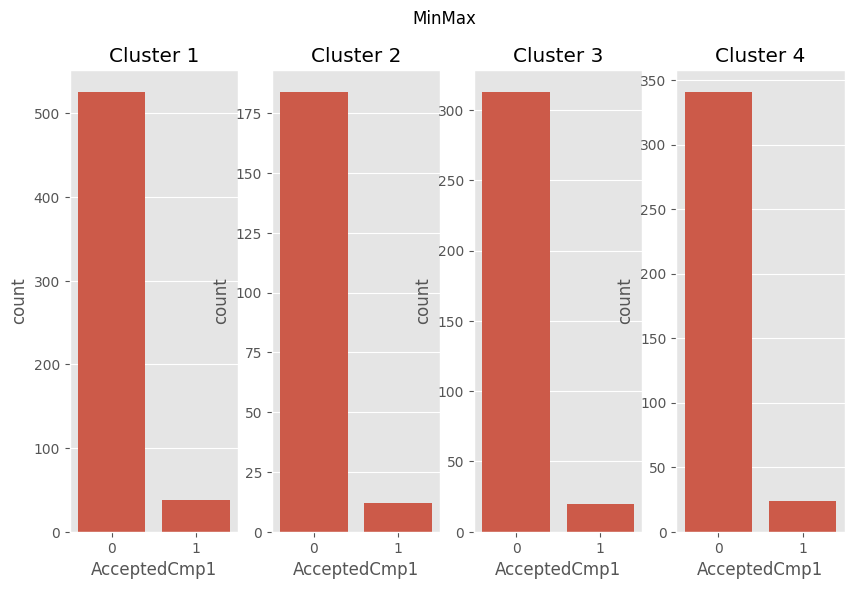

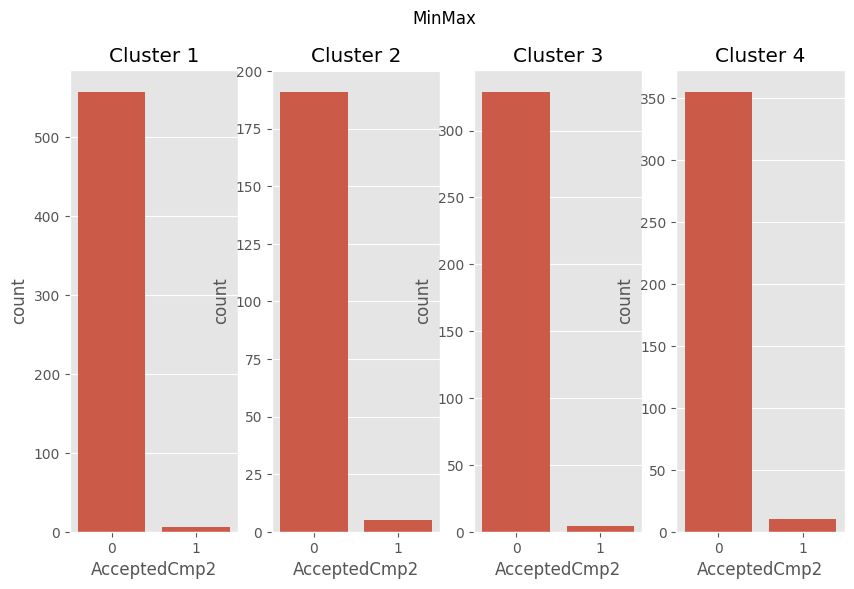

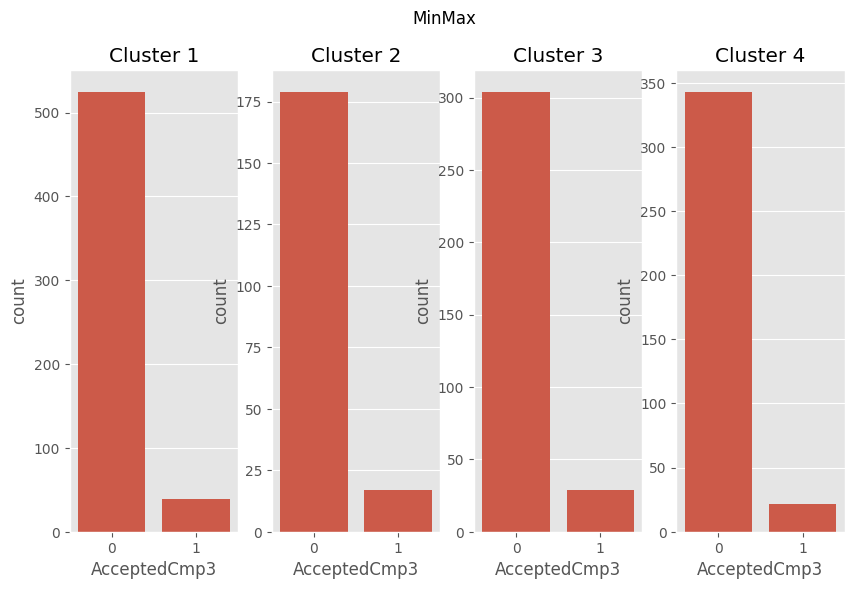

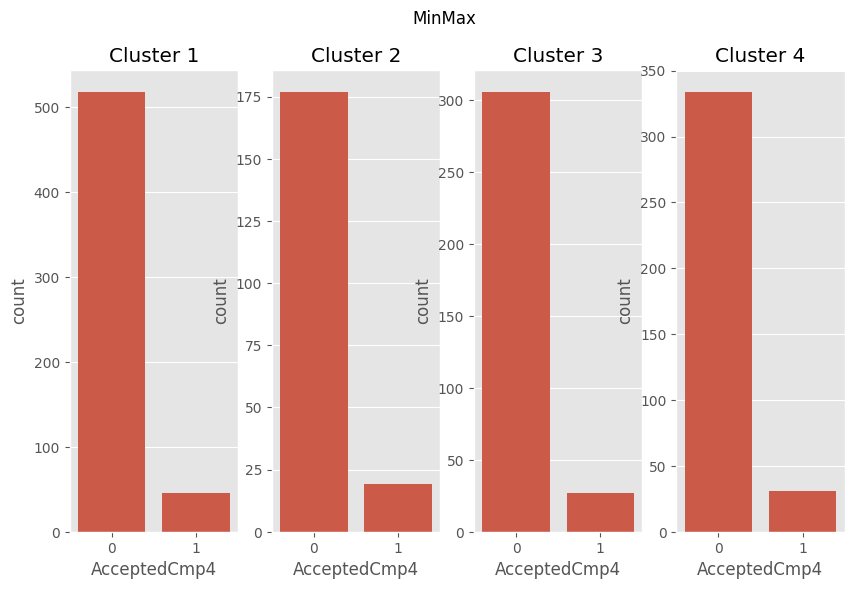

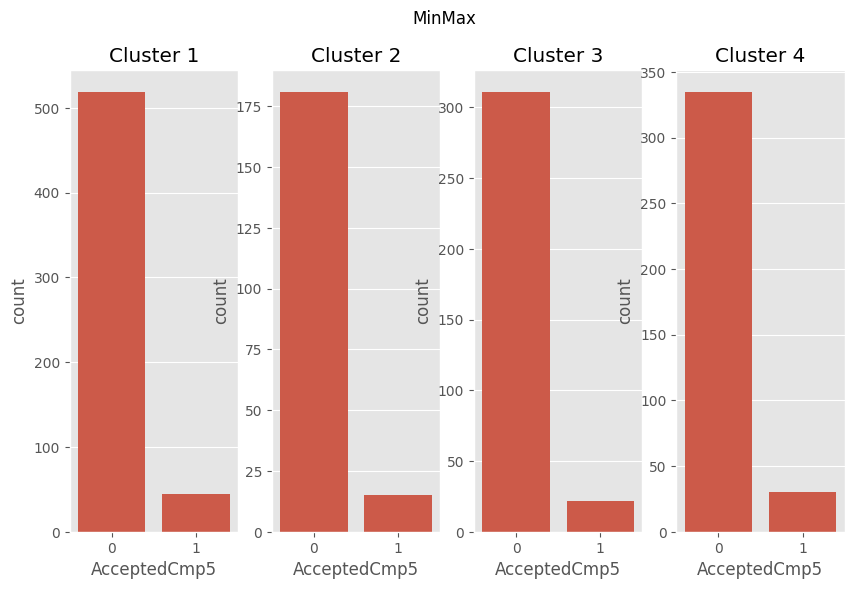

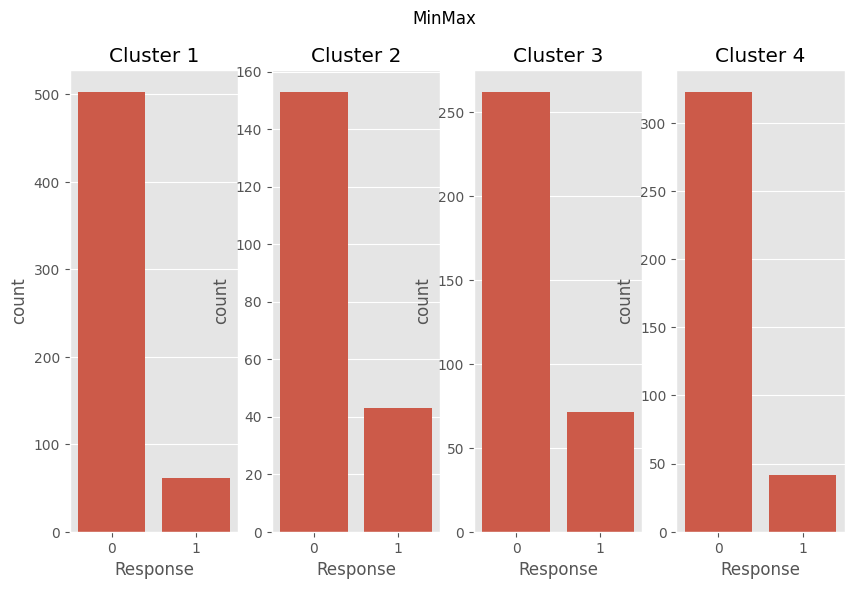

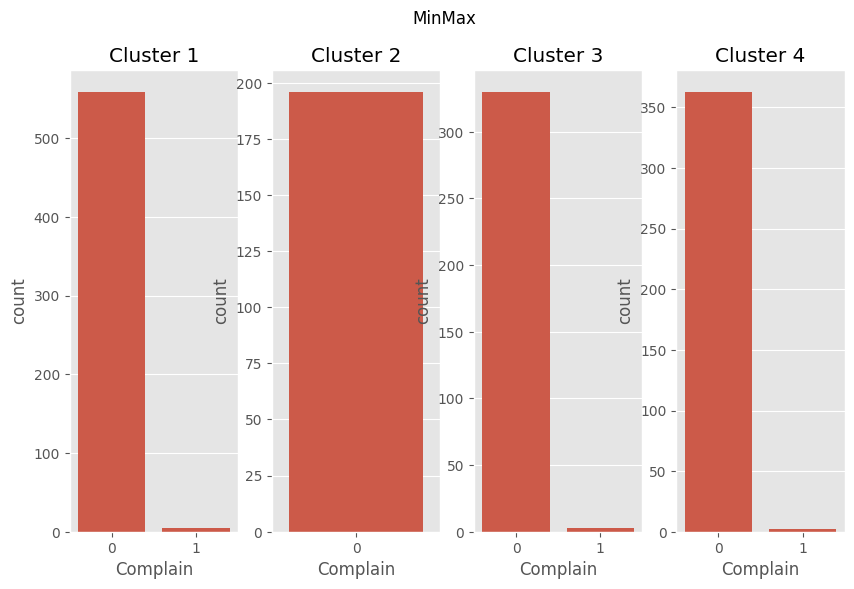

In [69]:
for label in labels_categorical:
    for i in range(4): # k=4
        cluster_labels = workdf[kmeans_mm.labels_ == i][label]
        plt.subplot(1, best_k_mm, i+1)
        sns.countplot(x=cluster_labels)
        plt.suptitle(f'MinMax')
        plt.title(f'Cluster {i+1}')
    plt.show() 

**Comparison and Comments:**
- The clusters seem to be based more on behavioral attributes like spending habits and digital engagement. The "Affluence and Consumption" principal component suggests an economic dimension, while the "Youth and Digital Engagement" component might reflect age and technology use.
- The clusters named "Digital Family", "Traditional Spenders", and "Affluent Connoisseurs" likely capture different economic segments and purchasing behaviors, which can be crucial for understanding customer preferences and designing tailored marketing campaigns.
- The "Digital Family" cluster, for instance, might indicate a target group for digital marketing campaigns, while "Affluent Connoisseurs" could be targeted for premium product offerings. or non-digital transactions.
Finally, we can see how MinMax outperforms Standardized Scaling, while still std provides relevant information, and thus we can say that both are beneficial in our use case as we saw earlier. Since by using both, we've got different clusters where each has its own description and criterion.

- The clustering here seems to differentiate customers based more on lifestyle or life stage characteristics, indicated by the prominence of marital status in the principal components.
- With clusters such as "Committed Partners" and "Independent Singles" the segmentation is more about the marital status and potentially associated lifestyle choices, which could inform different types of product offerings or communication strategies.
- "Young Partners" could represent a younger demographic that is not yet married but in a partnership, which could be a crucial demographic for certain products or services.

- Higher silhouette scores for the MinMax scaled data suggest that the clusters are more distinct than those from the standardized data.
- Depending on the business context, one set of clusters might be more actionable than the other. For instance, if marketing is more concerned with customer lifestyles, the MinMax scaled clusters could be more relevant. Conversely, if the focus is on customer spending power and online behavior, the standardized clusters might provide more insight. (Exact details are not specified in the homework - but still I did that like I was in a company)
- The clustering on the standardized data appears to highlight economic and behavioral differences, while the clustering on the MinMax scaled data brings out lifestyle-based distinctions.

Finally, we can say that this study refers on both scaled data, which allowed us to explore data more, and thus, we can say that we weren't able to explore this data in this way without doing these scales and playing with the world of dimensionality reduction and clustering. It was a great game! Where we've discovered too much things.